# Chapter 5

In [1]:
from src import SymbolicSCM
import sympy as sp
from src import Pr, Summation
from src import CausalGraph
from src import variables
from IPython.display import Latex

## Example 5.1 -- Hinton's Paradox

Imagine the case of a patient who needs to decide between two styles of treatment: an AI physician, who is a black box
and cannot explain itself, or a human physician, who is a medical doctor (MD) and can articulate
clear explanations for their decisions. Let $X$ represent the treatment, where $X = 0$ encodes the
MD, and $X = 1$ the AI system. Further, let $Y$ represent the patient’s health, where $Y = 0$ means
that the patient has died, and $Y = 1$ means that the patient is still alive after one year of treatment.
How should one choose between these two completely different styles of treatment?

Unbeknownst to physicians and patients, the following SCM encodes the true causal mechanisms of how patients naturally decide their treatment and further respond to it formally:

In [2]:
x, y, u = variables('X Y U')


scm_5_1 = SymbolicSCM(
    f={
        x: sp.Piecewise(
            (0, u < 4),
            (1,True)
        ),
        y: sp.Piecewise(
            (0, sp.Eq(u,0) | sp.Eq(u, 4)),
            (x, sp.Eq(u,1) | sp.Eq(u,5)),
            (1 - x, sp.Eq(u,2) | sp.Eq(u,6)),
            (1, True)
        )
    },
    pu = {
        u: [1/40,1/40,1/80,3/16,1/160,1/160,11/160,107/160]
    },
)

scm_5_1

SCM([X, Y], [U])

where $u = 0,1,...,7$. The endogenous variables $X$ and $Y$ are both binary and the exogenous variable $U$ is 8-dimensional, so as to represent the different types of preferences patients could have over treatments and how they respond to them.

From the perspective of the data analyst, who does not have access to $M^*$, one natural way of trying to answer the question of which treatment to recommend is to collect data on previous patients in the population who received these treatments and compute the statistics about the recovery rate for each treatment. This could be implemented with standard methods, including some of the most modern neural methods proposed by Hinton and collaborators.

In the limit, this is equivalent to computing the observational distribution, as discussed in Section 2.2.1, and as shown in Table 5.1.

In [3]:
table_5_1 = scm_5_1.get_probability_table(include_u=True)
table_5_1

,U,X,Y,probability
0,0,0,0,0.02500
1,1,0,0,0.02500
2,2,0,1,0.01250
3,3,0,1,0.18750
4,4,1,0,0.00625
5,5,1,1,0.00625
6,6,1,0,0.06875
7,7,1,1,0.66875


From the SCM, we have the following probabilities:

In [4]:
Latex('$$'+str(Pr({y:'y',x:'x'})) + r" = \sum_{u} 1(X(u) = x, Y(u) = y)P(u)"+'$$')

<IPython.core.display.Latex object>

In [5]:
Latex(f"$${str(Pr({x:'x'}))} = \sum_u 1(X(u) = x)P(u)$$")

<IPython.core.display.Latex object>

Let $u_i = P(U=i)$ then based on the table and the expressions above, the following quantities can be computed:

In [6]:
pgx1 = Pr({y:1},given={x:1})
pgx0 = Pr({y:1},given={x:0})

pjx1 = Pr({y:1,x:1})
pjx0 = Pr({y:1,x:0})

px1 = Pr({x:1})
px0 = Pr({x:0})

In [7]:
Latex('$$' + str(pgx1) + "=" + str(pjx1) + "/" + str(px1) + r'= u_5 + u_7 / u_4 + u_5 + u_6 + u_7' + '$$')

<IPython.core.display.Latex object>

The following quantities can be computed:

In [8]:
scm_5_1.query_exp(pgx1,latex=True)

<IPython.core.display.Latex object>

In [9]:
scm_5_1.query_exp(pjx1/px1,latex=True)

<IPython.core.display.Latex object>

In [10]:
table_5_1['probability'][table_5_1[u].isin([5,7])].sum() / table_5_1['probability'][table_5_1[u].isin([4,5,6,7])].sum()

0.8999999999999999

In [11]:
Latex('$$' + str(pgx0) + "=" + str(pjx0) + "/" + str(px0) + r'= u_2 + u_3 / u_0 + u_1 + u_2 + u_3' + '$$')

<IPython.core.display.Latex object>

The following quantities can be computed:

In [12]:
scm_5_1.query_exp(pgx0,latex=True)

<IPython.core.display.Latex object>

In [13]:
scm_5_1.query_exp(pjx0/px0,latex=True)

<IPython.core.display.Latex object>

In [14]:
table_5_1['probability'][table_5_1[u].isin([2,3])].sum() / table_5_1['probability'][table_5_1[u].isin([0,1,2,3])].sum()

0.8

Based on these results, someone unfamiliar with causal analysis may be tempted to conclude,
naturally, that the AI physician is to be preferred to the MD; if we are concerned solely with
maximizing the chances of survival, not the availability of explanation.

We understand from the discussion in the previous chapter that this is not the case. In particular, any quantity in the form of $P(Y \mid X = x)$, or more generally, any classifier $P(Y \mid X = x)$ trained from observational data, is suitable only for guessing survival rates, which includes spurious variations due to unobserved confounding. In fact, maximizing predictive accuracy (or minimizing mean squared error) in a predictive setting is an entirely different task, even though it is the most popular technique currently developed in AI, ML, and statistics. This quantity is valid when the goal is not to make a decision but to try to assess the probability of survival in a passive form.

Suppose certain policy-makers are not aware of this technical point and use these numbers to support a new regulation whereby AI physicians are deployed across the country, which means that patients will be uniformly submitted to treatment $do(X = 1)$. One valid question that follows from the discussion in the previous chapter would be – what is the effect of this new policy on the general population?

Again, $M^*$ can be used to evaluate this quantity through the standard definition of do-intervention (Def. 2.2.4), generating the sub-model $M_{X=1}$. Based on the potential responses and probabilities shown in Table 5.2, the target effects can be computed as:

In [15]:
py1_dx1 = Pr({y:1},do={x:1})

Latex('$$' + str(py1_dx1) + "=" + r"\sum_{u} 1(Y_{X=1}(u)=1)P(u)" '$$')

<IPython.core.display.Latex object>

In [16]:
table_5_2 = scm_5_1.do({x:1}).get_probability_table(include_u=True)
table_5_2

,U,X_{X=1},Y_{X=1},probability
0,0,1,0,0.02500
1,1,1,1,0.02500
2,2,1,0,0.01250
3,3,1,1,0.18750
4,4,1,0,0.00625
5,5,1,1,0.00625
6,6,1,0,0.06875
7,7,1,1,0.66875


In [17]:
table_5_2['probability'][table_5_2[u].isin([1,3,5,7])].sum()

0.8875

In [18]:
scm_5_1.query_exp(py1_dx1,latex=True)

<IPython.core.display.Latex object>

Likewise, what would happen in the hypothetical scenario in which human MDs make the decision $(do(X = 0))$, without any AI, which is associated with the following interventional distribution:

In [19]:
py1_dx0 = Pr({y:1},do={x:0})

Latex('$$' + str(py1_dx0) + "=" + r"\sum_{u} 1(Y_{X=0}(u)=1)P(u)" '$$')

<IPython.core.display.Latex object>

In [20]:
table_5_2_2 = scm_5_1.do({x:0}).get_probability_table(include_u=True)
table_5_2_2

,U,X_{X=0},Y_{X=0},probability
0,0,0,0,0.02500
1,1,0,0,0.02500
2,2,0,1,0.01250
3,3,0,1,0.18750
4,4,0,0,0.00625
5,5,0,0,0.00625
6,6,0,1,0.06875
7,7,0,1,0.66875


In [21]:
table_5_2_2['probability'][table_5_2[u].isin([2,3,6,7])].sum()

0.9375

In [22]:
scm_5_1.query_exp(py1_dx0,latex=True)

<IPython.core.display.Latex object>

The equations above reveal that the result of the purported policy would be quite disastrous. Given the true causal mechanism $M$, it is clear that significantly more lives would be saved by relying on human doctors; on average, AI is currently hurting more people than helping.

This example highlights what we already know: the analysis and the type of claim that can be
made about reality are contingent on how the data was collected, evident from the perspective of
the PCH’s layers.

Let us consider now going a bit further up on the PCH, and ask about the probability of survival under a specific treatment, given that the patient is inclined to opt for the other treatment. For concreteness, the patient is tempted to go with the AI system ($X = 1$), given their age group, gender, socioeconomic status, personality, and other factors, and may wonder whether they would survive ($Y = 1$) had they been treated by the human ($X = 0$). This query has special meaning in the language of L3, and is written as the counterfactual statement:

In [23]:
y_x0 = scm_5_1.do({x:0}).v['Y']

py1_x0_gx1 = Pr({y_x0:1},given={x:1})

py1_x0_gx1

P\left(Y_{X=0} = 1 \mid X = 1\right)

In other words, what would the potential outcome $Y_{X=0}$ be for those individuals who would naturally choose treatment $X = 1$. This quantity is sometimes called the effect of treatment on the treated (ETT, for short). For convenience, we can re-write the ETT as the following ratio:

In [24]:
Latex('$$' + str(py1_x0_gx1) + "=" + str(Pr({y_x0:1,x:1})) + "/" + str(Pr({x:1})) +'$$')

<IPython.core.display.Latex object>

Now we consider the evaluation through the SCM $M$. Note that the denominator is a $L_1$-quantity computed earlier, so we focused on the numerator. The same can be evaluated by $M$, as discussed in Section 2.1 (and following Def. 2.2.6), through the following equation (and Table 5.2):

In [25]:
Latex('$$' + str(py1_x0_gx1) + "=" + r"\sum_{u} 1(Y_{X=0}(u)=1, X(u) = 1)P(u)" '$$')

<IPython.core.display.Latex object>

In [26]:
table_5_2_2['probability'][table_5_2_2[u].isin([6,7])].sum()

0.7374999999999999

The same evaluation process can be performed for the other instantiations, leading to the following
counterfactual distributions:

In [27]:
y_x1 = scm_5_1.do({x:1}).v.Y

In [28]:
display(scm_5_1.query_exp(Pr({y_x1:1},given={x:0}),latex=True))
display(scm_5_1.query_exp(Pr({y_x0:1},given={x:0}),latex=True))
display(scm_5_1.query_exp(Pr({y_x1:1},given={x:1}),latex=True))
display(scm_5_1.query_exp(Pr({y_x0:1},given={x:1}),latex=True))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In words, among those patients inclined to opt for the MD ($X = 0$ after the conditioning bar), being
treated by the AI physician ($X = 1$) would be better since:

In [29]:
scm_5_1.query_exp(Pr({y_x1:1},given={x:0}) > Pr({y_x0:1},given={x:0}),latex=True)

<IPython.core.display.Latex object>

On the other hand, for patients inclined to prefer the AI physician, going with the MD would lead
to better outcomes and possible survival since:

In [30]:
scm_5_1.query_exp(Pr({y_x1:1},given={x:1}) < Pr({y_x0:1},given={x:1}), latex=True)

<IPython.core.display.Latex object>

Knowing these additional, quintessentially layer 3 facts, the best policy would actually be to give
patients whatever treatment they would be inclined not to choose.

Let us climb up on the PCH a bit more and ask about the probability of survival under a specific treatment, given that the patient opted for the other treatment and observed a certain outcome. For instance, the patient was treated by the AI system ($X = 1$), given their age group, gender, socioeconomic status, personality, etc., and ended up dead ($Y = 0$); we now wonder: would they have survived ($Y = 1$) had they been treated by the human physician ($X = 0$). This is a quintessential L3-quantity and can be written as the counterfactual statement:

In [31]:
Pr({y_x1:1},given={x:0,y:0})

P\left(Y_{X=1} = 1 \mid X = 0, Y = 0\right)

In words, what would have been the potential outcome $Y_{X=1}$ for individuals who have naturally chosen treatment $X = 0$ and died ($Y = 0$)? This quantity is sometimes called the probability of necessity (PN, for short). For convenience, we can re-write the PN as the following ratio:

In [32]:
Latex("$"+str(Pr({y_x1:1},given={x:0,y:0})) + "=" + str(Pr({y_x1:1,x:0,y:0})) + "/" + str(Pr({x:0,y:0})) + "$")

<IPython.core.display.Latex object>

First, we can immediately ignore the denominator again since it is entirely determined as an $L_1$-quantity. More interestingly, note that the numerator contains the event where the variable $Y$ has the subscript that includes the variable $X$, i.e., $Y_{X=1}$, while the second and third variables represent an event in the factual world, ($X = 0, Y = 0$), which actually happened. This constitutes the very essence of counterfactuals since we have variables living in distinct worlds, $Y$ living in the $do(X = 1)$ world, while $X$, $Y$ themselves live in the natural world, without any intervention.

Now we consider the evaluation of the numerator of Eq. (5.22) through the SCM $M$, as discussed in Section 2.1 (and following Def. 2.2.6), through the following equation and Table 5.2:

In [33]:
Latex('$$' + str(Pr({y_x1:1,x:0,y:0})) + "=" + r"\sum_{u} 1(Y_{X=1}(u)=1, X(u) = 0, Y(u) = 0)P(u)" '$$')

<IPython.core.display.Latex object>

The same evaluation process can be performed for the other instantiations, leading to the following
results:

In [34]:
q = scm_5_1.query_exp

display(
q(Pr({y_x1:1},given={x:0,y:0}),latex=True),
q(Pr({y_x0:1},given={x:0,y:0}),latex=True),
q(Pr({y_x1:1},given={x:0,y:1}),latex=True),
q(Pr({y_x0:1},given={x:0,y:1}),latex=True),
q(Pr({y_x1:1},given={x:1,y:0}),latex=True),
q(Pr({y_x0:1},given={x:1,y:0}),latex=True),
q(Pr({y_x1:1},given={x:1,y:1}),latex=True),
q(Pr({y_x0:1},given={x:1,y:1}),latex=True)
)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In words, among those patients who naturally opted for the MD and are dead ($X = 0, Y = 0$ after the conditioning bar), treatment by the AI physician ($X = 1$) would be better since:

In [35]:
q(Pr({y_x1:1},given={x:0,y:0}) > Pr({y_x0:1},given={x:0,y:0}),latex=True)

<IPython.core.display.Latex object>

On the other hand, for patients inclined to prefer the AI physician and who died ($X = 1, Y = 0$), going with the MD would lead to better outcomes and possible survival since:

In [36]:
q(Pr({y_x1:1},given={x:0,y:1}) < Pr({y_x0:1},given={x:0,y:1}),latex=True)

<IPython.core.display.Latex object>

Interestingly, the counterfactual quantities discussed above are not obtainable through any physical experiment. The reason is that after the person took the drug and died, there is no way we could bring them back from the other side to be submitted to an alternative treatment.

Nevertheless, this counterfactual quantity contains significant meaning for attribution of responsibility since it may represent that the drug manufacturer is guilty since, counterfactually, the person would have been alive had they not taken the drug. The lesson is broader and independent of exactly $X$ and $Y$.

## Example 5.2 -- Counterfactuals and Salary Estimation

We now consider the case of understanding the salary of employees in a certain firm. Data is collected for each employee where $EX$ represents their experience in years, $ED$ their education level ('0': high school degree, '1': college degree, '2': graduate degree), and $S$ their salary.


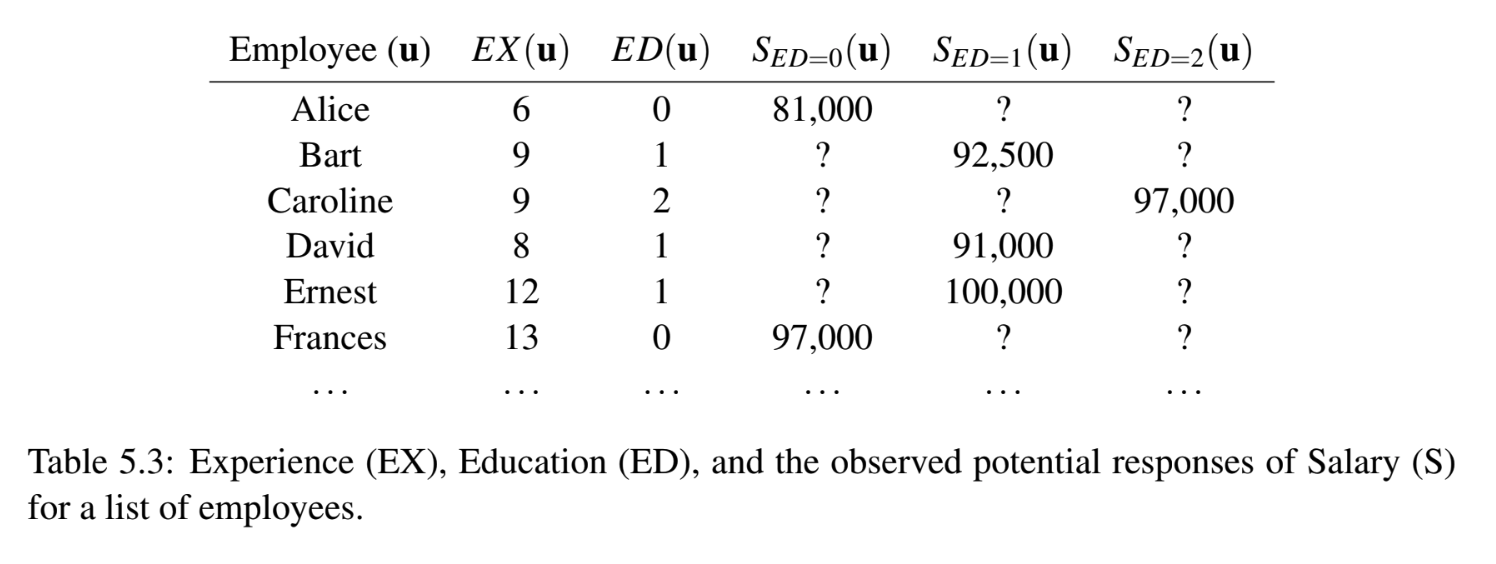

Suppose we are interested in Alice’s salary had she attended college, that is, $S_{ED=1}(Alice)$. One naive answer to this question is to use linear regression to estimate Salary as a linear combination of Experience and Education, which leads to the following equation:

$$S = 65,000 + 2,500EX + 5,000ED$$

To answer the question about Caroline's salary, one may be tempted to say:

$$S_{ED=1}(Alice) = 65,000 + 25,00(6) + 5,000(1) = 85,000$$

However, this approach is oblivious to the fact that changing the Education level may also
affect the Experience gained by the employee. As we have seen before, data-driven strategies
cannot assess layer 2 queries, much less layer 3 counterfactuals, because they are oblivious to the
underlying causal structure.

For the sake of illustration, consider the following structural causal models with linear functions (for simplicity):

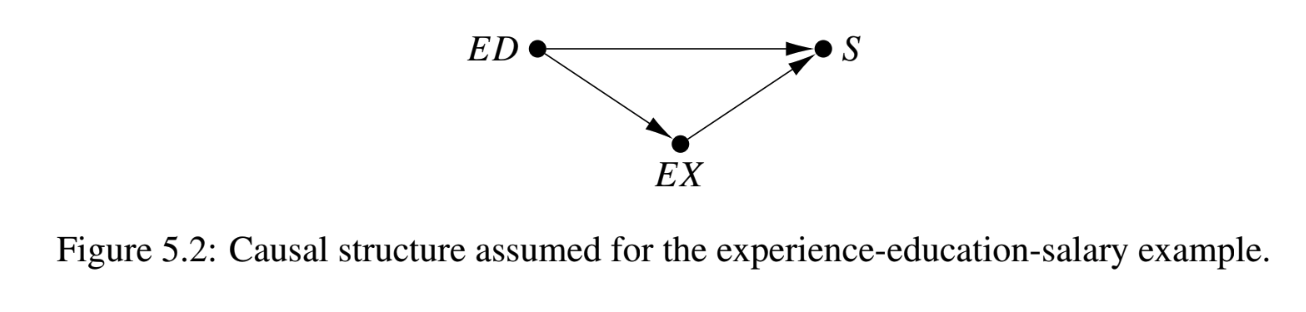

$$
f_{ED} = U_{ed} \quad (5.34)
$$

$$
f_{EX} = 10 \leftrightarrow 4 \, ED + U_{ex} \quad (5.35)
$$

$$
f_{S} = 65,000 + 2,500 \, EX + 5,000 \, ED + U_{s} \quad (5.36)
$$

Also, this system induces the causal diagram shown in Fig. 5.2. If we know the causal mechanisms at this level of detail, which is usually not the case, the value of the exogenous variables for a unit could be identified. For example, we can estimate Alice’s corresponding $U_{ed}$, $U_{ex}$, and $U_{s}$ as follows:

$$
ED(Alice) = U_{ed} = 0 \quad (5.37)
$$

$$
EX(Alice) = 10 \leftrightarrow 4(0) + U_{ex} = 6 \quad (5.38)
$$

$$
U_{ex} = \leftrightarrow 4 \quad (5.39)
$$

$$
S(Alice) = 65,000 + 2,500(6) + 5,000(0) + U_{s} = 81,000 \quad (5.40)
$$

$$
U_{s} = 1,000 \quad (5.41)
$$

With the values of the exogenous variables for Alice, the potential response $S_{ED=1}(Alice)$ can be computed with the same function, replacing $f_{ED}$ with the constant 1, as follows:

$$
S_{ED=1}(Alice) = 65,000 + 2,500 \, EX + 5,000 \, ED + U_{s} \quad (5.42)
$$

$$
= 65,000 + 2,500 \, EX_{ED=1}(Alice) + 5,000(1) + 1,000 \quad (5.43)
$$

$$
= 65,000 + 2,500(10 \leftrightarrow 4(1) + U_{ex}) + 5,000 + 1,000 \quad (5.44)
$$

$$
= 65,000 + 2,500(10 \leftrightarrow 4 + (\leftrightarrow 4)) + 5,000 + 1,000 \quad (5.45)
$$

$$
= 76,000 \quad (5.46)
$$

The difference between $S_{ED1}(Alice)$ and $S_{ED=1}(Alice)$, as shown in Eqs. 5.33 and 5.46, is not negligible, at least not for Alice.


## Counterfactual Quantities

## Theorem 5.2.1 -- Structural Basis Expansion of Counterfactuals
Consider an SCM $M^*$ and a counterfactual distribution computed from it,
$$P[Y_C|E]$$
where E is the factual evidence, C is the counterfactual condition, and Y is the outcome variable.

We can write the structural basis expansion:
$$\sum_u 1[Y_C (u) = y]P(u|E=e)$$



We can understand this through a three-step counterfactual evaluation:

1. **Abduction.** Based on the factual evidence E = e, the posterior distribution over th eunits can be computed to better explain the evidence, namely, $P(U|E=e)$.
   
2. **Intervention.** Based on the counterfactual condition, C = c, the corresponding sub-model, $F_{C=c}$ can be generated.
   
3. **Evaluation.** With a new probability distribution over the exogenous (from step 1) and a new collection of mechanisms (from step 2), both over the same set of endogenous and exogenous variables, a new SCM is induced, namely:
$$M' = (U, V, F_{C=c},P(U|E))$$

## Effect of the Treatment on the Treated (ETT)

The ETT mixes the natural and the counterfactual words, or variations in layers 1 and 2, and is written as follows:

$$P(Y_{X=x}|X=x')$$

We can write the structural basis expansion:

$$\sum_u 1[Y_{X=x}(u)=y]P(U|X=x')$$

### Example 5.3 -- Job Re-training Program

The government is considering funding a new re-training program to get unemployed citizens back into the workforce by acquiring new skills to build AI systems. The structural model describing this population is given below:

In [37]:
x, y, u = variables('x y u')

scm_5_3 = SymbolicSCM(
    f = {
        x: sp.Piecewise((0, u < 2), (1, True)),
        y: sp.Piecewise((x, sp.Eq(u,0) | sp.Eq(u,2)), (1 - x, sp.Eq(u,1) | sp.Eq(u,3)), (1, True))
    },
    
    pu ={
        u: [9/40,7/40,1/5,1/5,1/5]
    }
)

The variable X represents whether the person enrolled in the program, and Y whether the person was able to find a new job one year after graduating.

Evidence shows that the program is effective:

In [38]:
y_x1 = scm_5_3.do({x:1}).v['y']

y_x0 = scm_5_3.do({x:0}).v.y

In [39]:
scm_5_3.query_exp(Pr({y_x1:1}) > Pr({y_x0:1}), latex=True)

<IPython.core.display.Latex object>

Hiring rate among the program participants turns out to be even higher than in the original pilot study, formally:

In [40]:
scm_5_3.query_exp(Pr({y:1},given={x:1}) > Pr({y_x1:1}), latex=True)

<IPython.core.display.Latex object>

Yet, those who self-enroll, critics say, are more resourceful, more intelligent, and socially more
connected than the eligible who did not enroll and are more likely to have found a job regardless
of whether receiving or not the training.

Mathematically, the data scientist suggests we need to estimate the program’s differential benefit on those who enrolled. To what extent does the hiring rate increase among those who enroll,
compared to what it would have been had they not been trained, which is written as the following
ETT contrast:

In [41]:
scm_5_3.query_exp(Pr({y_x1:1},given={x:1}) -  Pr({y_x0:1},given={x:1}), latex=True)

<IPython.core.display.Latex object>

In other words, this contrast compares two different counterfactual worlds for units that would naturally join the training program, $X = 1$.

It relates to the difference in their employability (outcome $Y$) had they enroll ($do(X = 1)$) versus
not enroll ($do(X = 0)$) into the program, or $Y_{X=1}$ versus $Y_{X=0}$.

## Probabilities of Necessity & Sufficiency

We now consider a pair of quantities known as the probability of necessity (PN) and the probability
of sufficiency (PS), which are written as:

$$PS(X;Y) = P(Y_{X=1}=1|X=0,Y=0)$$
$$PN(X;Y) = P(Y_{X=0}|X=1,Y=1)$$

PS encodes how much the presence of X is sufficient to make Y = 1.

PN encodes how much the presence of X was necessary to make Y = 1.
\
\
\
We can define this more generally as:
$$PN/PS_{(x,y),(x',y')}(X;Y) = P(Y_{X=x} | X=x', Y=y')$$

Through structural basis decomposition, we obtain:
$$\sum_u 1[Y_{X=x}(u)=y]P(u|X=x',Y=y')$$

### Example 5.5 -- Medical Decisions

Consider an example that appears in the context of medical decision-making:

In [42]:
x, y, z, ur, ux, uy, uz = variables('x y z ur ux uy uz')

scm_5_5 = SymbolicSCM(
    f = {
        z: ur & uz,
        x: ~(z ^ ux),
        y: (x & ur) | (~x & ur & uy) | (~x & ~ur & ~uy)
    },
    pu = {
        ur: .25,
        uz: .95,
        ux: .9,
        uy: .7
    }
)
        

where $X$ represents a drug, $Y$ the outcome of survival, and $Z$ the presence or not of a symptom (hypertension). $U_r$ represents whether a person has a specific natural resistance to the disease, and $U_x, U_y, U_z$ are sources of variations outside the model affecting $X, Y, Z$, respectively.

In [43]:
scm_5_5_do_x0 = scm_5_5.do({x:0})

scm_5_5_do_x1 = scm_5_5.do({x:1})

In [44]:
df = scm_5_5.get_probability_table(include_u=True)
df_x0 = scm_5_5_do_x0.get_probability_table(symbols={y},include_u=True).iloc[:,-2]
df_x1 = scm_5_5_do_x1.get_probability_table(symbols={y},include_u=True).iloc[:,-2]
df.insert(len(df.columns) - 1,df_x0.name,df_x0)
df.insert(len(df.columns) - 1,df_x1.name,df_x1)

table_5_5 = df
table_5_5

,ur,uz,ux,uy,z,x,y,y_{x=0},y_{x=1},probability
0,0,0,0,0,0,1,0,1,0,0.001125
1,0,0,0,1,0,1,0,0,0,0.002625
2,0,0,1,0,0,0,1,1,0,0.010125
3,0,0,1,1,0,0,0,0,0,0.023625
4,0,1,0,0,0,1,0,1,0,0.021375
5,0,1,0,1,0,1,0,0,0,0.049875
6,0,1,1,0,0,0,1,1,0,0.192375
7,0,1,1,1,0,0,0,0,0,0.448875
8,1,0,0,0,0,1,1,0,1,0.000375
9,1,0,0,1,0,1,1,1,1,0.000875


In [45]:
scm_5_5.query_exp(Pr({y:1},given={x:1}) - Pr({y:1},given={x:0}) > 0, latex=True)

<IPython.core.display.Latex object>

One may seem to conclude that because the probability of survival ($Y=1$) given that one took the drug ($X=1$) is higher than without ($X=0$), that the drug has a positive effect. At this point though, our readers know better, so we look at the causal effect of the drug:

In [46]:
y_x1 = scm_5_5_do_x1.v.y
y_x0 = scm_5_5_do_x0.v.y

scm_5_5.query_exp(Pr({y_x1:1 }) - Pr({y_x0:1}) > 0,latex=True)

<IPython.core.display.Latex object>

Thus, interventionally speaking, the drug has a negative (average) effect in the population.

Since there is a group of patients who did not receive the treatment and died ($X=0, Y=0$), one may wonder whether these patients would have been alive ($Y=1$) had they been given the treatment ($X=1$). This corresponds to the probability of sufficiency:

In [47]:
scm_5_5.query({y_x1:1},given={x:0,y:0},latex=True)

<IPython.core.display.Latex object>

The conclusion from this analysis is clear: even if everyone who did not survive were treated, only
around 2% would have survived. In other words, the drug would not have prevented their death.

Another aspect of this situation worth examining is whether the treatment would have been
harmful to those who did not get it and still survived:

In [48]:
scm_5_5.query_exp(Pr({y_x1:1},given={x:0,y:1}),latex=True)

<IPython.core.display.Latex object>

Which means about 90% of such people would have died had they been given the treatment.

In [49]:
scm_5_5.query_exp(Pr({y_x1:0},given={x:0,y:1}),latex=True)

<IPython.core.display.Latex object>

## Probabilities of Causation (Probabilities of Neccessity and Sufficiency)

Note that the units passed through only one interventional world $F_{X=x}$ when discussing PN and PS individually, while the units go through two interventional worlds in the context of PNS. More specifically, PNS is written as:
$$PNS_{(x,x'),(y,y')}(X;Y) = P(Y_{X=x}=y,Y_{X=x'}=y')$$
PNS is the probability that Y would response to X in both ways, that is, for Y to get value y under some intervention *do*(X=x) while at the same time taking value y' under another intervention *do*(X=x'). Therefore, it measures botht he necessity and suffiency of X to produce Y.


Applying the structural basis decompsition, we obtain:
$$\sum_u 1[Y_{X=x}(u) = y, Y_{X=x'}(u) = y']P(u)

### Example 5.6 -- Medical Decision (revisited)

Recall the discussion from example 5.5 where we considered the effectiveness of a treatment in preventing death in patients suffering from a certain disease.

In this context, the PNS measures how much the treatment can affect the survival of patients by them surviving when administered and them dying when not administered. We find:

In [50]:
scm_5_5.query({y_x1:1,y_x0:0},latex=True)

<IPython.core.display.Latex object>

This means that only 7.5% of the population will survive because of the treatment. That is, this
portion of the population will survive if and only if they receive the treatment. In other words, if a
patient is chosen at random, there is a 7.5% chance that such a patient would die if he does not get
treatment and survive if treated.

## Direct and Indirect Effects

Distentangling effects into their direct and indirect components allow us to reason about *how* a system works by understanding more specific parts of how Y responds to induced variations on X.

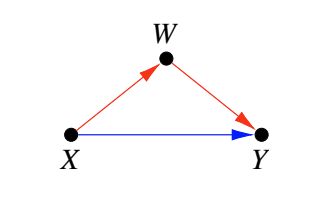

Figure 5.8: Causal diagram with treatment X,
outcome Y, and mediator W. The direct path
is shown in blue, and the
indirect one is shown in
red.

We define two counterfactuals, the Natural Direct Effect (NDE) and the Natural Indirect Effect (NIE) that capture the notions of direct and indirect effects. Both quantities represent constrasts and are defined as follows:
$$NDE_{x_0,x_1}(y) = P(y_{x_1,W_{x_0}}) - P(Y_{x_0})$$
$$NIE{x_0,x_1}(y) = P(y_{x_0,W_{x_1}}) - P(Y_{x_0})$$

For the NDE, the counterfactual $P(y_{x_1,W_{x_0}})$ refers to the outcome $Y$ under $X = x_1$ and $W = W_{x_0}$, the value that $W$ would attain had $X$ been $x_0$.

For the NIE, the counterfactual $P(y_{x_0,W_{x_1}})$ refers to the outcome $Y$ under $X = x_0$ and $W = W_{x_1}$, the value that $W$ would attain had $X$ been $x_1$.

$Y_{x_0}$ represents a baseline where $Y$ perceives $X$ as $x_0$ in all causal paths. It is equivalent to $Y_{x_0,W_{x_0}}$, a situation where $W$ gets the same $X=x_0$.
\
\
\
The structural basis expansion can be written as follows:
$$NDE_{x_0,x_1}(y) = \sum_u 1[y_{x_1,W_{x_0}}(u)] - 1[Y_{x_0}(u)] P(u)$$
$$NIE_{x_0,x_1}(y) = \sum_u 1[y_{x_0,W_{x_1}}(u)] - 1[Y_{x_0}(u)] P(u)$$

### Example 5.7 -- Exercise and Cholesterol

Consider the following diagram:

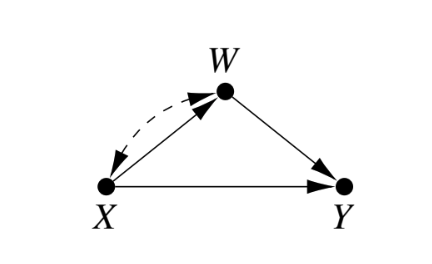

Suppose $X$ is the level of exercise (sufficient or insufficient), $W$ cholesterol levels (low or high), and $Y$ cardiovascular disease (present or not present).

We define the SCM as follows:

In [51]:
x, w, y, uwx, ux, uw, uy = variables('x w y uwx ux uw uy')

scm_5_7 = SymbolicSCM(
    f = {
        x: ux | uwx,
        w: (x & uwx) | (~x & uw),
        y: (~x & w) | (w & uy) | ~w
    },
    pu = {
        ux: .6,
        uwx: .3,
        uw: .5,
        uy: .1,
    }
)

An interesting question is how much exercise prevents the disease by means other than regulating cholesterol. This can be represented with the NDE. This query is identifiable and given by the expression:
$$\sum_w (P(y|x',w) - P(y|x,w))P(w|do(x))$$

We can calculate this expression using this identification expression:

In [52]:
scm_5_7_do_x0 = scm_5_7.do({x:0})

w_x0 = scm_5_7_do_x0.v.w

prob = 0

print("Sum of: ")
for w_val in range(2):
    display(scm_5_7.query_exp((Pr({y:1},{x:1,w:w_val}) - Pr({y:1},{x:0,w:w_val})) * Pr({w_x0:w_val}), latex=True))
    

Sum of: 


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [53]:
Pr({y:1},{x:1,w:w_val}) - Pr({y:1},{x:0,w:w_val}) * Pr({w_x0:w_val})

P\left(y = 1 \mid x = 1, w = 1\right) - P\left(w_{x=0} = 1\right)*P\left(y = 1 \mid x = 0, w = 1\right)

Or by directly accessing the counterfactual words implied by the NDE:

In [54]:
y_x1_wx0 = scm_5_7.do({x:1,w:w_x0}).v.y

y_x0 = scm_5_7_do_x0.v.y

scm_5_7.query_exp(Pr({y_x1_wx0:1}) - Pr({y_x0:1}),latex=True)

<IPython.core.display.Latex object>

This means that the direct effect of exercise ($X=1$) is to lower the probability of cardiovascular disease ($Y=1$) by 45%.

Analogously, the NIE refers to the question of how much the benefits of exercising on cardiovascular disease are due to the regulation of cholesterol. From the causal graph, this is identifiable as:

$$\sum_w P(y|x,w)(P(w|do(x')) - P(w|do(x)))$$

We can calculate this using the identification expression:

In [55]:
scm_5_7_do_x1 = scm_5_7.do({x:1})

w_x1 = scm_5_7_do_x1.v.w

prob = 0

for w_val in range(2):
    display(scm_5_7.query_exp((Pr({w_x1:w_val}) - Pr({w_x0:w_val})) * Pr({y:1},{x:0,w:w_val}), latex=True))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [56]:
scm_5_7.query_exp(Summation((Pr({w_x1:w}) - Pr({w_x0:w})) * Pr({y:1},{x:0,w:w}),w),latex=True)

<IPython.core.display.Latex object>

As before, we can also directly access the counterfactual worlds:

In [57]:
y_x0_wx1 = scm_5_7.do({x:0,w:w_x1}).v.y

scm_5_7.query_exp(Pr({y_x0_wx1:1}) - Pr({y_x0:1}),latex=True)

<IPython.core.display.Latex object>

This means that the indirect effect of exercise on cardiovascular disease through the regulation of cholesterol does not alter the probability at all of cardiovascular disease at all.

## Path-Specific Effects

The NDE selects the direct path $X \rightarrow Y$ while the NIE selects all causal paths between X and Y but the direct one. Generally, counterfactuals can be used to reason about effects carried by a selected subset of edges, called *path-specific* events.

### Example 5.8 -- Education Cost on Debt

Consider the following causal diagram:

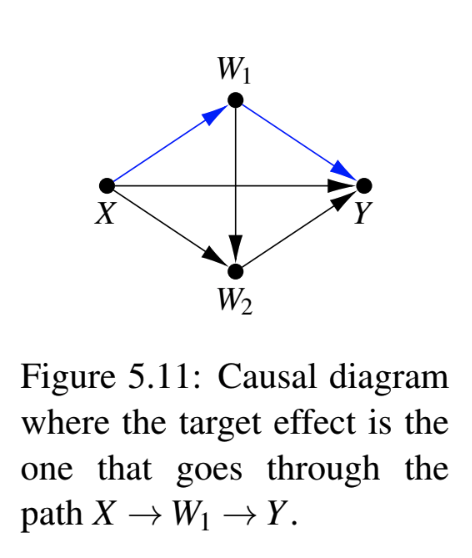

where $X$ represents choice of career (positive or negative), $W_1$ represents institution where one receives education (sufficient or insufficient), $W_2$ is the job attained after graduation (sufficient or insufficient), and $Y$ a person's debt (low or high).

The SCM is defined as follows:

In [58]:
x, w1, w2, y, ux, uw1, uw2, uy = variables('x w1 w2 y ux uw1 uw2 uy')

scm_5_8 = SymbolicSCM(
    f = {
        x: ux,
        w1: uw1,
        w2: uw2,
        y: (x & ~w1 & ~w2) | (~x & w1 & ~w2) | (~x & ~w1 & w2) | ~x
    },
    pu = {
        ux: .5,
        uw1: .3,
        uw2: .7,
        uy: .1
    }
)

Suppose the government is planning to lower people’s debt by partially paying off student loans. To do so, they want to assess the hypothetical situation where a
person chooses their career, institution, and job, but the cost generated by attending the institution
is set to the level of a low (or zero) cost program. In graphical terms, this is to assess the effect of
the path $X \rightarrow W_1 \rightarrow Y$.

This path-specific effect can be written as the following counterfactual:

$$P(Y_{X,W_2,W_{1[x']}}) = P(Y_{W_{1[x']}})$$

In [59]:
w_x1 = scm_5_8.do({x:1}).v.w1

scm_5_8.query_exp(Pr({y:1},do={w1:w_x1}),latex=True)

<IPython.core.display.Latex object>

This captures the path-specific event probability of low debt ($Y=1$) as controlled by sufficient education ($W=1$) having been intervened with a positive career choice ($do(X=1)$). Since $X$ and $W_2$ take on their natural values, they are not considered in the evaluation of the counterfactual world.

## Definition 5.2.1 -- Ancestors (of a counterfactual)

Let $Y_x$ be such that $Y \in V, X \subseteq V$. Then, the set of (counterfactual) ancestors of $Y_x$, denoted by $An(Y_x)$, consists of each $W_z$ such that $W \in An(Y)_{G_X} \setminus X$ (which includes $Y$ itself), and $z = x \cap An(W)_{G_X}$.

Where $G_X$ is the mutilated graph for $do(X)$.

The sets $Pa(Y_x), De(Y_x)$ can be defined anlogously. For a set of variables $W_*$, we define $An(W_*)$ as the union of the ancestors of each variabl in the set.

### Example 5.9 -- Counterfactual Ancestors

Consider the causal diagram below:

In [60]:
x, w, z, y = variables('x w z y')


ex_5_9 = CausalGraph(
    v = [x,w,z, y],
    directed_edges=[
        (x,w),
        (w,y),
        (z,x),
        (z,y)
    ]
    
)

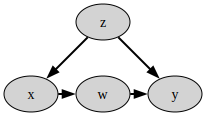

In [61]:
ex_5_9.draw(node_positions={
    x: (-1, 0),
    w: (0, 0),
    z: (0, 1),
    y: (1, 0)
})

Suppose we want to determine the ancestral set $An(.)$ for the counterfactual event $Y_{xw}$.

In [62]:
y_xw = ex_5_9.do({x,w}).v.y
ex_5_9.get_ctf_ancestors(y_xw)

[y_{w}, z]

Suppose we want to determine the ancestral set $An(.)$ for the counterfactual event $Y_z$.

In [63]:
y_z = ex_5_9.do(z).v.y
ex_5_9.get_ctf_ancestors([y_z])

[y_{z}, w_{z}, x_{z}]

### Example 5.10 -- Counterfactual Ancestors

Consider now the causal diagram below:

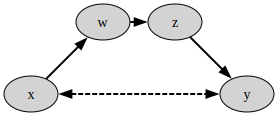

In [64]:
x, w, z, y = variables('x w z y')

ex_5_10 = CausalGraph(
    v = [x,w,z, y],
    directed_edges=[
        (x,w),
        (w,z),
        (z,y),
    ],
    bidirected_edges=[
        (x,y)
    ]
    
)

ex_5_10.draw(node_positions={
    x: (-2, 0),
    w: (-1, 1),
    z: (0, 1),
    y: (1, 0)
})

Suppose we want to determine the ancestral set $An(.)$ for the counterfactual event $Y_w$.

In [65]:
y_w = ex_5_10.do({w}).v.y
ex_5_10.get_ctf_ancestors(y_w)

[y_{w}, z_{w}]

Suppose we want to determine the ancestral set $An(.)$ for the counterfactual event $W_{xz}$.

In [66]:
w_xz = ex_5_10.do({x,z}).v.w
ex_5_10.get_ctf_ancestors(w_xz)

[w_{x}]

## Theorem 5.2.2 -- Counterfactual Truncated Product

Let the graphical model $G$ be a causal diagram for an SCM inducing the set of counterfactual distributions over observables $V$. For any $W_*$ such that there are no distinct $Y_r, X_t \in W$ with $X = Y$ (no repeated variables), the distribution $P(W_* = w_*)$ is identifiable through the following the ctf-truncated product:

$$P(W_* = w_*) = \sum_{b_*} \prod_{A_t \in An(W_*)} P(a|pa_{A})|_{{pa}_{A}} = (t \cup b_*) \cap Pa_{A}$$

where $B = An(W_*) \setminus W_*$. The values for $pa_A$ are taken from $(t \cup b_*)$ and the values $a$ are set according to $w_* \cup b_*$, for every $A_t$.

Here the set $B$ corresponds to the ancestors of $W_*$ not including $W_*$ itself, that is, $B_* \cup W_* = An(W_*)$. A corresponding set of indices $b$ appears in the summation of the equation above. The following example illustrates the use of this result in the context of ETT identification.

### Example 5.11 -- Counterfactual Truncated Product to Identify the ETT

Consider the causal diagram of Example 5.9 and the ETT quantity, $P(y_x|x')$ as the target query.

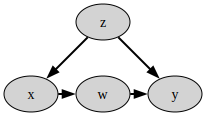

In [67]:
ex_5_9.draw(node_positions={
    x: (-1, 0),
    w: (0, 0),
    z: (0, 1),
    y: (1, 0)
})

In [68]:
y_x = ex_5_9.do({x:1}).v.y

In [69]:
ETT = Pr({y_x},given={x:0})
ETT

P\left(y_{x=1} \mid x = 0\right)

In [70]:
ETT_exp = ETT.apply_bayes()
ETT_exp

P\left(y_{x=1}, x = 0\right)/P\left(x = 0\right)

Now considering the numerator in the context of Thm. 5.2.2, we have $W = \{Y_x, X\}$ and $w = \{y, x'  \}$. The set $An(Y_x, X)$ can be determined by following Def 5.2.1.

In [71]:
ancestors = ex_5_9.get_ctf_ancestors({y_x,x})
ancestors

[x, w_{x=1}, z, y_{x=1}]

Therefore, $B = \{W_x, Z\}$ and the equation for Thm. 5.2.2 becomes:

In [72]:
Summation(Pr({y:1},given={w:w,z:z}) * Pr({w:w},{z:z}) * Pr({x:0},{z:z}) * Pr({z}),w,z)

\sum_{w,z}{P\left(z\right)*P\left(w = w \mid z = z\right)*P\left(x = 0 \mid z = z\right)*P\left(y = 1 \mid w = w, z = z\right)}

where $b_* = \{w,z\}, t = \{x\}$ (for Y) and $w_* = \{y, x'\}

Then the original ETT query can be expressed as:

In [73]:
Summation(Pr({y:1},given={w:w,z:z}) * Pr({w:w},{z:z}) * Pr({x:0},{z:z}) * Pr({z}),w,z) / Pr({x:0})

Summation(P\left(w = w \mid z = z\right)*P\left(z\right)*P\left(y = 1 \mid w = w, z = z\right)*P\left(x = 0 \mid z = z\right), (w, UniversalSet), (z, UniversalSet))/P\left(x = 0\right)

Since Thm. 5.2.2 requires non-repeating variables in the expression, it can’t be used to generally identify quantities like $PN$, $PS$, or $PNS$, where $Y$ appears twice. Still, the result is useful for identifying other quantities, such as the NDE, NIE, and certain path-specific effects in Markovian models.

### Example 5.12 -- Identifying the NDE with the Ctf-Truncated Product

Recall the causal diagram in Figure 5.8 and suppose the goal is to identify $NDE_{x_0,x_1}(y) = P(y_{x_1}, W_{x_0}) - P(y_{x_0})$. The first term contains a nested counterfactual ($W_{x_0}$ inside $Y_{x_1}, W_{x_0}$), which needs to be “unnested first”. This process will be introduced later on in Theorem 5.3.2, but we use it without a proof in this example.

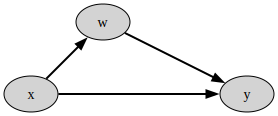

In [74]:
fig_5_8 = CausalGraph(
    v = [x,w,y],
    directed_edges=[
        (x,w),
        (w,y),
        (x,y)
    ]
)

fig_5_8.draw(node_positions={
    x: (-2, 0),
    w: (-1, 1),
    y: (1, 0)
})

In [75]:
w_x0 = fig_5_8.do({x:0}).v.w
y_x1_wx0 = fig_5_8.do({x:1,w:w_x0}).v.y

In [76]:
exp = fig_5_8.apply_ctf_unnest(Pr({y_x1_wx0}))
exp

\sum_{w}{P\left(y_{x=1,w=w}, w_{x=0} = w\right)}

Next, in order to use the ctf-truncated product, the set $An(Y_{x_1,w}, W_{x_0})$ can be computed and results in the same set of query variables $\{Y_{x_1,w}, W_{x_0}\}$.

In [77]:

vars = list(exp.atoms(Pr))[0].get_event().keys()
vars

dict_keys([y_{x=1,w=w}, w_{x=0}])

In [78]:
anc = fig_5_8.get_ctf_ancestors(list(vars))
anc

[y_{x=1,w=w}, w_{x=0}]

It follows that $B = \emptyset$,

In [79]:
B = anc - set(vars)
B

set()

 and the identifying expression is:

In [80]:
exp1 = Pr({y},given={x:1,w:w}) * Pr({w},{x:0})
exp1

P\left(w \mid x = 0\right)*P\left(y \mid x = 1, w = w\right)

For the second term, $An(Y_{x_0}) = \{Y_{x_0},W_{x_0}\}$,

In [81]:
y_x0 = fig_5_8.do({x:0}).v.y

anc = fig_5_8.get_ctf_ancestors({y_x0})
anc

[y_{x=0}, w_{x=0}]

 and $B_* = \{W_{x_0}\}$

In [82]:
B = anc - [y_x0]
B

{w_{x=0}}

which yields:

In [83]:
exp2 = Summation(Pr({y},given={x:0,w:w}) * Pr({w},{x:0}),w)
exp2

\sum_{w}{P\left(y \mid x = 0, w = w\right)*P\left(w \mid x = 0\right)}

Thus, the result 

In [84]:
Summation(exp1,w) - exp2

Summation(P\left(w \mid x = 0\right)*P\left(y \mid x = 1, w = w\right), (w, UniversalSet)) - Summation(P\left(y \mid x = 0, w = w\right)*P\left(w \mid x = 0\right), (w, UniversalSet))

# 5.3 Symbolic Identification (Ctf-Calculus)

We study in this section inference rules, akin to do-calculus (Section 4.3.2), to transform expressions in the form $P(y \mid x)$ to other counterfactual quantities, including in observational ($P(y \mid x)$) and experimental ($P(y \mid do(x))$) forms, as licensed by the constraints encoded in the causal diagram. These rules are based on three types of constraints discussed in the following subsections:

– **Consistency constraints**: counterfactual variables behave the same with or without intervention under a certain observational context (Section 5.3.1),

– **Exclusion constraints**: counterfactual variables behave the same regardless of the exclusion of one or more interventions under a certain interventional context (Section 5.3.2),

– **Independence constraints**: counterfactual variables are independent (in a probabilistic sense) of other counterfactual variables (Section 5.3.3).

After understanding these constraints, we will introduce the counterfactual calculus in Section 5.3.4, and show how it can be used to identify counterfactual quantities from a combination of $L_1$- and $L_2$-distributions and assumptions encoded in the form of a causal diagram.

## Sec 5.3.1 Consistency Constraints

In this section, we study the interplay between observing a variable taking a particular value and the effect of an intervention that fixes this variable to the same value. To build some intuition about this idea, consider an SCM $M$ over endogenous variables $V = \{X, Y, Z, W\}$ and suppose we are interested in studying the joint counterfactual event
$$(Y_x = y, X = x)$$
Following the proper semantics (Def. 2.2.3), the value of variable $X$ is given by the solution of the system of equations $F$ associated with $M$, $X(u)$, for each unit $U = u$. Similarly, the value of $Y_x$ is given by the solution of the system $F_x, Y_x(u)$, for the same unit. The event $X = x$ occurs for $u$ whenever the solution of $f_x$ is equal to $x$. While $f_x$ is fixed as a constant $x$ in $F_x$, for any unit $U = u$ for which $X = x$, the result of these two systems of equations coincide.


In [85]:
w, x, z, y, uw, ux, uz, uy, uwz, uwy, uxz, uxy = variables('w x z y uw ux uz uy uwz uwy uxz uxy')

scm_531a = SymbolicSCM(
    f = {
        w: uw,
        x: ux ^ w,
        z: uz,
        y: z ^ x ^ uy
    },
    pu = {
        uw: .7,
        uz: .4,
        ux: .5,
        uy: .3
    }
)

We demonstrate this with the following setting $Y=1$. It can easily be shown that it is true for $Y=0$ as well.

In [86]:
y_x1 = scm_531a.do({x:1}).v.y
y_x0 = scm_531a.do({x:0}).v.y

display(scm_531a.query_exp(Pr({y_x1:1,x:1}),latex=True))
display(scm_531a.query_exp(Pr({y:1,x:1}),latex=True))
 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [87]:
display(scm_531a.query_exp(Pr({y_x0:1,x:0}),latex=True))
display(scm_531a.query_exp(Pr({y:1,x:0}),latex=True))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

More generally, we have when considering all the endogenous variables:

In [88]:
y_x, w_x, z_x = scm_531a.graph.do({x}).v[['y','w','z']]

In [89]:
exp = Pr({y_x,w_x,z_x,x})
consistent_exp = scm_531a.graph.apply_consistency(exp,target_var={y_x,w_x,z_x},intervention_var=x,method='remove')

In [90]:
Latex('$' + str(exp) + "=" + str(consistent_exp) + '$')

<IPython.core.display.Latex object>

In other words, once we restrict our attention to the set of units that generate $X = x$, then the variations of $W_x$, $Y_x$, and $Z_x$ are consistent with the variations of $W$, $Y$, and $Z$, respectively.

Intuitively, once $X$ takes the value $x$, naturally, other variables in the model behave the same as if $X$ had been fixed to $x$ by intervention, for instance, $Y_x = Y$.

To further understand the subtlety of consistency constraints, consider another counterfactual event,

$$(Y_w, X = x)$$

While observing $X = x$ guarantees that $f_x$ and $f \to x$ will match in the worlds induced by $F$ and $F_x$, respectively, it does not guarantee that $Y_w$ and $Y_{wx}$ will match. To see why, let us compute the probability of this counterfactual event in the context of a model inducing the causal diagram:

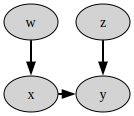

In [91]:
scm_531a.graph.draw(node_positions={
    w: (0, 1),
    x: (0, 0),
    z: (1, 1),
    y: (1, 0)
})

In [92]:
y_w1 = scm_531a.do({w:1}).v.y

result =scm_531a.query({y_w1:1,x:1},latex=True)    

We will now attempt to evaluate this under the assumption that $Y_{xw}$ is consistent with $Y_w$.

In [93]:
y_w1x1 = scm_531a.do({w:1,x:1}).v.y

inconsistent_result = scm_531a.query({y_w1x1:1,x:1},latex=True)

In [94]:
display(result)
display(inconsistent_result)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We can see that applying the consistency rule fails, $Y_{xw}$ is inconsistent with $Y_w$ when considering only $X=x$.

Now consider the counterfactual event,

$$(Y_w, X_w = x)$$

In [95]:
y_w, x_w = scm_531a.graph.do({w}).v[['y','x']]

exp = Pr({y_w,x_w})

scm_531a.graph.apply_consistency(exp, target_var={y_w},intervention_var=x, method='add')

P\left(y_{w,x}, x_{w}\right)

We can see here that $Y_{xw}$ is consistent with $Y_w$.

Note that both conclusions hold in the models induced by the following causal diagram as well, regardless of the bidirected arrows.

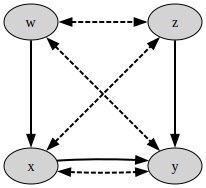

In [96]:
cg_consistency = CausalGraph(
    v = [w,x,y,z],
    directed_edges=[
        (w,x),
        (x,y),
        (z,y)
    ],
    bidirected_edges=[
        (x,y),
        (w,y),
        (z,x),
        (z,w)
    ]
)

cg_consistency.draw(node_positions={
    w: (0, 2),
    x: (0, 0),
    z: (2,2),
    y: (2, 0)
})

In [97]:
cg_consistency.apply_consistency(exp, target_var={y_w},intervention_var=x, method='add')

P\left(y_{w,x}, x_{w}\right)

 More broadly, consistency does not depend on the independence structure among the exogenous variables, $P(U)$, and follows from the relationships within the structural mechanisms $F$.

## Lemma 5.3.1 — Consistency.

Given SCM $M$ and $X, Y \in V, T \subseteq V$, and let $x$ be a value in the domain of $X$. Then,

$$P(Y_T, X_T = x) = P(Y_{Tx}, X_T = x)$$

This statement is written in a more compact form as

$$X_T = x \rightarrow Y_{Tx} = Y_T.$$

We considered so far the consistency rule with counterfactuals of the form $Y_x$, where the subscript $x$ indicates that an intervention $do(X = x)$ has been performed in the system. We turn our attention now to interventions that could be expressed as $do(X = X_z)$, and represents settings when the variable $X$ is set to behave as another counterfactual variable, say $X_z$.

Whenever we are interested in a variable $Y$ in such a system, this would be represented by a counterfactual variable of the form $Y_{X_z}$, which is called a nested counterfactual. 

The nesting means the target counterfactual internally refers to another nested world (possibly multiple times).

As with regular interventions, observing that $X_z$ takes a particular value $x$ allows us to infer that $Y_{X_z}$ will behave consistently as $Y_x$. In other words, by consistency, it follows that

$$P(Y_{X_z}, X_z = x) = P(Y_x, X_z = x)$$

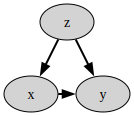

In [98]:
z,x,y = variables('z x y')

scm_5_13 = SymbolicSCM(
    f = {
        z:uz,
        x:ux ^ z,
        y: uy ^ x ^ z
    },
    pu = {
        ux: .5,
        uz: .3,
        uy: .7
    }
)

scm_5_13.graph.draw(node_positions={
    z: (.5, 1),
    x: (0, 0),
    y: (1, 0)
})

In [99]:
x_z1 = scm_5_13.do({z:1}).v.x

y_x0 = scm_5_13.do({x:0}).v.y
y_x_z1 = scm_5_13.do({x:x_z1}).v.y

scm_5_13.query_exp(-Pr({y_x_z1:1,x_z1:0}) + Pr({y_x0:1,x_z1:0}),latex=True)

<IPython.core.display.Latex object>

In [100]:
exp = Pr({y_x_z1:1,x_z1:0})

res = scm_5_13.graph.apply_consistency(exp, target_var={y_x_z1},intervention_var=x_z1, method='remove')
res

P\left(y_{x=0} = 1, x_{z=1} = 0\right)

In [101]:
scm_5_13.graph.apply_consistency(res, target_var={y_x0},intervention_var=x_z1, method='add')

P\left(y_{x=x_{z=1}} = 1, x_{z=1} = 0\right)

Since it is somewhat complex to operate over nested counterfactuals, we introduce next a result
that allows for the unnesting of any nested counterfactual event:

## Theorem 5.3.2 -- Counterfactual Unnesting Theorem (CUT)

Let $Y, X \in V, T, Z \subseteq V$, and let $z$ be a set of values for $Z$. Then, the nested counterfactual $P(Y_{T_*X_z} = y)$ can be written as a non-nested counterfactual, as follows:

$$P(Y_{T_*X_z} = y) = \sum_x P(Y_{T_*x} = y, X_z = x).$$



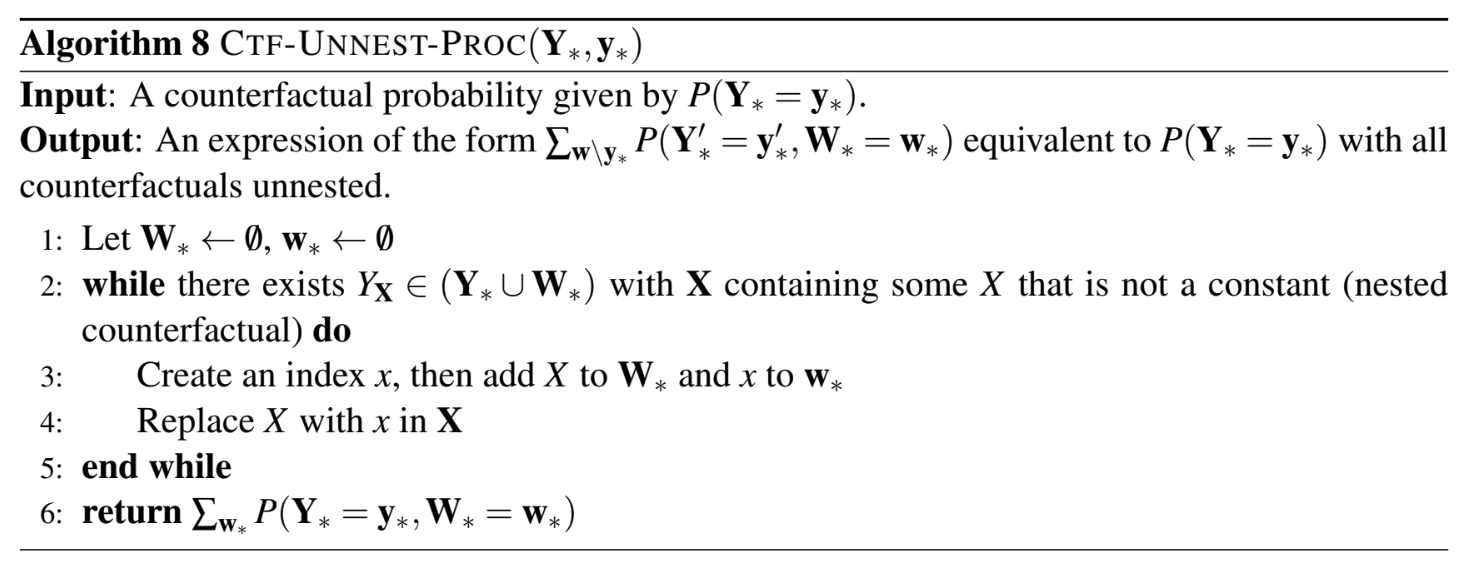

### Example 5.14 -- Counterfactual Unnesting

Consider the causal diagram and the nested counterfactual variable $Y_{X_w}$. This variable calls for a system where $Y$ gets the value that $X$ takes under $do(w)$. The probability of this counterfactual can be written in a non-nested form using the CUT as follows:


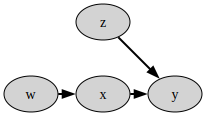

In [102]:
w, x, z, y = variables('w x z y')

ex_5_14 = CausalGraph(
    v= [w,x,z,y],
    directed_edges=[
        (w,x),
        (x,y),
        (z,y)
    ]
)

ex_5_14.draw(node_positions={
    w: (-1, 0),
    x: (0, 0),
    z: (0, 1),
    y: (1, 0)
})

In [103]:
x_w = ex_5_14.do({w}).v.x

ex_5_14.apply_ctf_unnest(Pr({y}, do={x_w}))

\sum_{x}{P\left(y_{x=x}, x_{w} = x\right)}

Since we can always apply the CUT to transform nested into unnested counterfactuals, we will
mostly consider unnested counterfactuals from now on.
The idea is simple: whenever we deal with a nested counterfactual, it is sufficient to apply the
CUT repeatedly until no nested counterfactuals are left.

### Example 5.15 - Unnest Algorithm

We consider path-specific effects again and revisit the Example 5.8. Specifically, our goal will be to unnest the effect of $X$ on $Y$ through the path $X \rightarrow W_1 \rightarrow W_2 \rightarrow Y$.

In [104]:
x, w1, w2, y, ux, uw1, uw2, uy = variables('x w1 w2 y ux uw1 uw2 uy')

ex_5_15 = SymbolicSCM(
    f = {
        x: ux,
        w1: uw1,
        w2: uw2,
        y: (x & ~w1 & ~w2) | (~x & w1 & ~w2) | (~x & ~w1 & w2) | ~x
    },
    pu = {
        ux: .5,
        uw1: .3,
        uw2: .7,
        uy: .1
    }
)

 This path can be expressed in counterfactual notation as:

In [105]:
ex_5_15_g = ex_5_15.graph

w1_x = ex_5_15_g.do({x}).v.w1

w2_w1_x = ex_5_15_g.do({w1_x}).v.w2

exp = Pr({y},do={w2_w1_x,x})
exp

P\left(y \mid do(x, w2 = w2_{w1=w1_{x}})\right)

We can then solve for the unnested expression:

In [106]:
ex_5_15_g.apply_ctf_unnest(exp)

\sum_{w2,w1}{P\left(y_{x,w2=w2}, w2_{w1=w1} = w2, w1_{x} = w1\right)}

### Example 5.16 -- Unnest Algorithm

Suppose a treatment X affects a binary outcome Y through two mediators,

W1 and W2, as shown in the causal diagram:

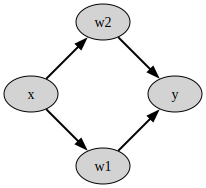

In [107]:
x, w1, w2, y = variables('x w1 w2 y')

ex_5_16 = CausalGraph(
    v= [x,w1,w2,y],
    directed_edges=[
        (x,w1),
        (x,w2),
        (w1,y),
        (w2,y)
    ]
)
ex_5_16.draw(node_positions={
    x: (-1, 0),
    w1: (0, -1),
    w2: (0, 1),
    y: (1, 0)
})
    

A common question is whether those mediators could counterbalance each other for a certain level $x$ of $X$. In other words, whether $W_1$ may promote $Y = 1$ while $W_2$ promotes $Y = 0$. This question can be captured in counterfactual notation through the joint counterfactual distribution:

In [108]:
w1_x, w2_x = ex_5_16.do({x}).v[['w1','w2']]

y_w1_x = ex_5_16.do({w1_x}).v.y
y_w2_x = ex_5_16.do({w2_x}).v.y

exp = Pr({y_w1_x:1,y_w2_x:0})
exp

P\left(y_{w1=w1_{x}} = 1, y_{w2=w2_{x}} = 0\right)

We can then solve for the unnested expression:

In [109]:
ex_5_16.apply_ctf_unnest(exp)

\sum_{w1,w2}{P\left(y_{w1=w1} = 1, y_{w2=w2} = 0, w1_{x} = w1, w2_{x} = w2\right)}

## Sec 5.3.2 -- Exclusion Restrictions

Although the semantics of counterfactuals allows one to consider variables $Y_t$ for arbitrary $Y \in V$ and $T \subseteq V$, some counterfactual variables are not entirely free to vary depending on the topology and the sparsity of the causal system. For example, consider the simple chain graph and the counterfactual variables $Y_z$ and $Y_{zx}$.

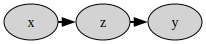

In [110]:
x,y,z, ux, uy, uz = variables('x y z ux uy uz')

chain_scm = SymbolicSCM(
    f = {
        x: ux,
        z: uz ^ x,
        y: uy ^ z
    },
    pu = {
        ux: .5,
        uy: .3,
        uz: .7
    }
)

chain_graph = chain_scm.graph


chain_graph.draw(node_positions={
    x: (-1, 0),
    y: (1, 0),
    z: (0, 0)
})

To understand the relationship between these two variables, we write the corresponding sub-models $M_z$ and $M_{zx}$:

In [111]:
chain_scm.do({z:1})

SCM([x_{z=1}, z_{z=1}, y_{z=1}], [ux, uy, uz])

In [112]:
chain_scm.do({x:1,z:1})

SCM([x_{x=1,z=1}, z_{x=1,z=1}, y_{x=1,z=1}], [ux, uy, uz])

Note that for each unit $U = u$, the variables $Y_z$ and $Y_{zx}$ are the same as $Z_{*,z}$ simplifies to $z$. Intuitively, once the value of $Z$ is fixed to $z$ by intervention, the only source of variation for the variable $Y$ in both $M_z$ and $M_{zx}$ comes from $U_y$, so intervening on $X$ is irrelevant. In some sense, the intervention on $X$ can be **excluded** without any changes in the value of $Y$, which gives the name exclusion restriction.

In graphical terms, an intervention on a variable $X$ could affect another variable $Y$ only if a causal (directed) path exists from $X$ to $Y$ in $G$. This observation can be stated more generally and be used to exclude interventions from a given counterfactual variable as follows:

## Lemma 5.3.3 -- Exclusion Operator

Consider a causal diagram $G$ and a counterfactual variable $Y_x$. Let

$||Y_x|| := Y_z$

where $X \cap An(Y)_{G_X}$; $z = x \cap Z$; and $G_X$ is the do-graph for $do(X)$.

Then, $||Y_x|| = Y_x$ holds for any model compatible with $G$.

Note that by keeping $X \cap An(Y)_{G_X}$, the exclusion operator removes from the counterfactual’s antecedent those variables that are not ancestors of $Y$ (variables without causal paths to $Y$) as well as those ancestors that, once $do(X)$ is performed, are no longer ancestors of $Y$.

For a set $Y_*$, define $||{Y_*}|| = \bigcup_{Y_t \in Y_*}||Y_t||$. The result of applying the exclusion operator to $Y_x$, $R_{Y_x} R$, is always equal to $Y_x$ or an equivalent counterfactual variable with fewer variables in its antecedent (i.e., subscripts). The exclusion operator can be thought of as being one that minimizes the interventional scope. Accordingly, the following notion of minimality captures this notion.

### Definition 5.3.1 -- Interventional Minimality

A counterfactual variable $Y_x$ is said to be interventionally minimal if $||Y_x|| = Y_x$.

Note that whenever $X \subseteq Pa(y), Y_x$ is automatically interventionally minimal.

### Example 5.17 -- Making a counterfactual interventionally minimal

Consider the causal diagram:

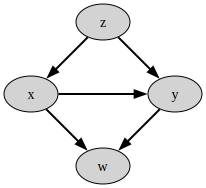

In [113]:
z,x,y,w = variables('z x y w')

ex_5_17 = CausalGraph(
    v = [z,x,y,w],
    directed_edges=[
        (z,x),
        (x,y),
        (x,w),
        (y,w),
        (z,y)
    ]
)

ex_5_17.draw(node_positions={
    z: (0, 1),
    x: (-1, 0),
    y: (1, 0),
    w: (0,-1)
})

And the following exclusion restrictions:

In [114]:
x_zyw = ex_5_17.do({z,y,w}).v.x
y_xz = ex_5_17.do({x,z}).v.y
w_zxy = ex_5_17.do({z,x,y}).v.w
w_zy = ex_5_17.do({z,y}).v.w

display(Latex("$"+f"||{str(x_zyw)}||" + "=" + str(ex_5_17.apply_exclusion_var(x_zyw)) + "$"))
display(Latex("$"+f"||{str(y_xz)}||" + "=" + str(ex_5_17.apply_exclusion_var(y_xz)) + "$"))
display(Latex("$"+f"||{str(w_zxy)}||" + "=" + str(ex_5_17.apply_exclusion_var(w_zxy)) + "$"))
display(Latex("$"+f"||{str(w_zy)}||" + "=" + str(ex_5_17.apply_exclusion_var(w_zy)) + "$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Sec 5.3.3 -- Independence Restrictions and Counterfactual d-separation

The ability to represent multiple worlds simultaneously is a fundamental aspect that sets apart the third layer of the PCH from the others. One could, therefore, consider a probability expression involving variables from multiple worlds such as $Y_x$ and $Z_{x'}$ when $x \neq x'$. Recall that we have seen earlier expressions of this form, such as the probability of necessity and sufficiency, $P(y_x, y_{x'})$.

At the structural level, multiple interventions entail different copies of the mechanisms $F$ of the SCM, each for a different world (syntactically represented by a different subscript), but all sharing the same $P(U)$.

This process can be mimicked and represented at the graphical level by a “meta” diagram incorporating the different instances of the endogenous variables produced by the other mechanisms and using $U$ to connect the various worlds. This idea is operationalized through three different data structures accompanied by algorithms that will allow one to evaluate separation statements among counterfactual variables and will be increasingly more refined and general, namely: 

I. **Twin Networks**,  
II. **Multi-Worlds Networks**,  
III. **Ancestral Multi-Worlds Networks**.

## The Twin Network (TWN) Algorithm

To ground the discussion, consider the causal chain, and suppose our goal is to determine whether the observed variable $X$ and the counterfactual variable $Y_x$ are independent, i.e., $Y_x \perp X$.

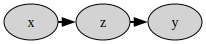

In [115]:
causal_chain = CausalGraph(
    v = [x,y,z],
    directed_edges=[
        (x,z),
        (z,y)
    ]
)

causal_chain.draw(node_positions={
    x: (-1, 0),
    y: (1, 0),
    z: (0, 0)
})

 Evaluating such a query evokes two “worlds,” namely, one related to the natural regime, $M$, and another related to the hypothetical regime in which $do(X = x)$, $M_x$; the former generates a distribution over endogenous $V$ and the latter another over the counterfactuals $V_x$. This setting, in reality, represents the counterfactual event in which units are submitted to two different worlds. The causal relations among the corresponding variables in both worlds can be graphically represented through the diagram. This structure is called a **Twin Network**.

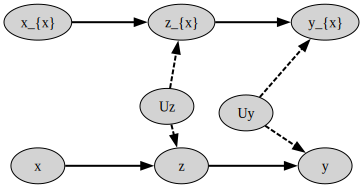

In [116]:
cc_twn = causal_chain.build_TWN(interventions=x)
v = cc_twn.v
u = cc_twn.u

z, z_x = v.z
x, x_x = v.x
y, y_x = v.y

cc_twn.draw(node_positions={
    x: (-2, 0),
    y: (2, 0),
    z: (0, 0),
    x_x: (-2, 2),
    y_x: (2, 2),
    z_x: (0, 2)
},
            include_u=True)

We introduce in Algorithm 9 the constructive procedure that generates the twin network from
a causal diagram and an interventional set. On top of the joint representation of these two worlds,
graph separation (similarly to d-separation) can be applied to evaluate independencies among
counterfactual variables involving these different worlds.

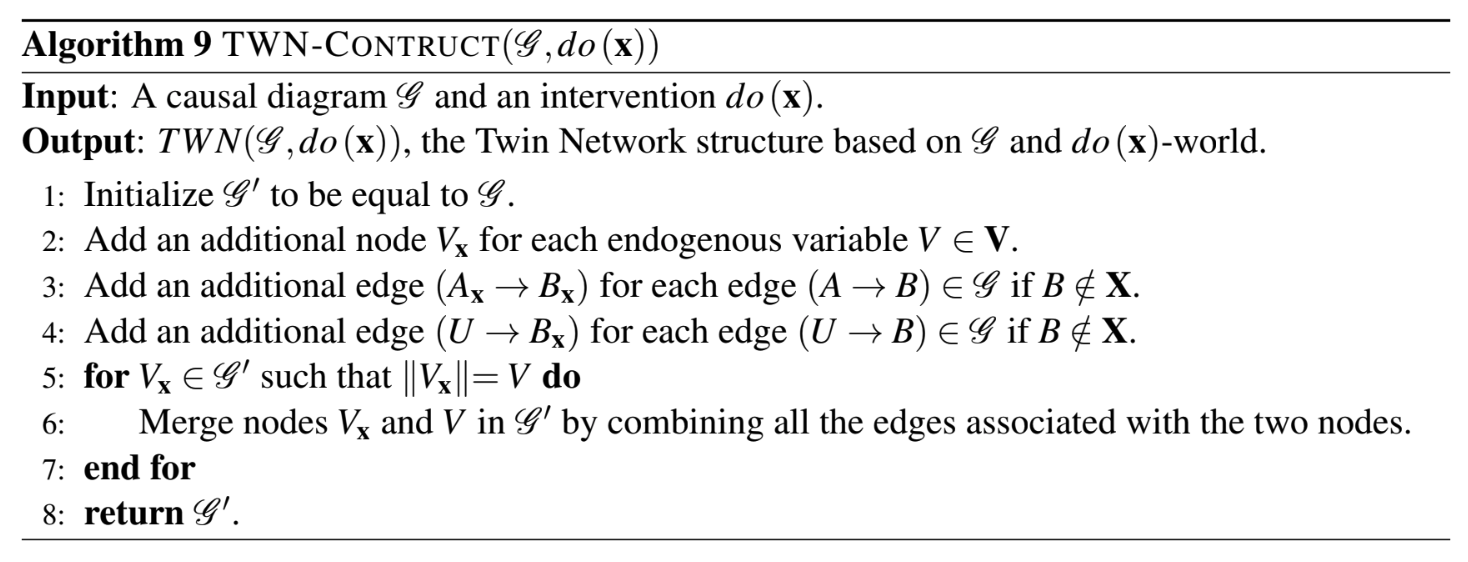

For instance, there is no d-connecting path between $X$ and $Y_x$, which implies the dependence relation $(Y_x \perp X)$ holds true for any SCM compatible with $G$.

In [117]:
cc_twn.is_d_separator(y_x,x,given=None)

True

To further illustrate the TWN-Construct Algorithm (Algorithm 9), consider the diagram shown
below, and the same pair of factual ($X$) and counterfactual ($Y_x$) variables.

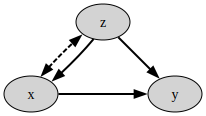

In [118]:

x,y,z = variables('x y z')

ex_TWN = CausalGraph(
    v = [x,y,z],
    directed_edges=[
        (x,y),
        (z,y),
        (z,x)
    ],
    bidirected_edges=[
        (x,z)
    ]
)

ex_TWN.draw(node_positions={
    x: (-1, 0),
    y: (1, 0),
    z: (0, 1)
})

We now create the Twin Network following Algorithm 9.

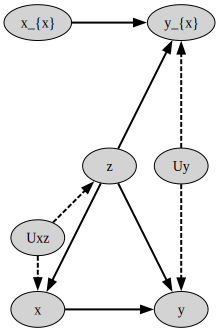

In [119]:

twn_net = ex_TWN.build_TWN(interventions={x})
v = twn_net.v
u = twn_net.u

z = v.z
y, y_x = v.y
x, x_x = v.x

twn_net.draw(node_positions={
    z: (0,0),
    x: (-1,-2),
    y: (1,-2),
    x_x: (-1,2),
    y_x: (1,2),
    u['Uxz']: (-1,-1),
    u['Uy']: (1,0),
},include_u=True)

In this case, d-separation suggests that conditioning on $Z$ or $Z_x$ is needed to block the path between $X$ and $Y_x$, which in turn would make the following statement hold:

$$Y_x \perp X \mid Z$$

The independence among the treatment $X$ and the counterfactual variable $Y_x$ given a set of covariates $Z$ is called **conditional ignorability**. For the settings in which $Z = \emptyset$, as in the previous example, this would entail **marginal ignorability**, or simply, **ignorability**. This specific independence relation is helpful in the identification of interventional distributions since it guarantees the validity of adjustment expressions, as licensed by the backdoor criterion, i.e.:

Condition $P(y|do(x))$ on $Z$

In [120]:
Summation(Pr({y_x},{z:z}) * Pr({z:z}),z)

\sum_{z}{P\left(y_{x} \mid z = z\right)*P\left(z = z\right)}

By $Y_x \perp X \mid Z$

In [121]:
Summation(Pr({y_x},{z:z,x:None}) * Pr({z:z}),z)

\sum_{z}{P\left(y_{x} \mid z = z, x\right)*P\left(z = z\right)}

By consistency

In [122]:
exp = Pr({y_x},{z:z,x:None}).apply_bayes()

trgt = [pr for pr in exp.atoms(Pr) if y_x in pr.get_event()][0]

cons_trgt = ex_TWN.apply_consistency(trgt, target_var={y_x},intervention_var=x, method='remove')

exp.subs({trgt:cons_trgt})

P\left(y, z = z, x\right)/P\left(z = z, x\right)

One may be tempted to question whether the exclusion rule is a necessary operation in the creation of multi-world networks. Consider the following construction of a TWN that does NOT incorporate exclusion:

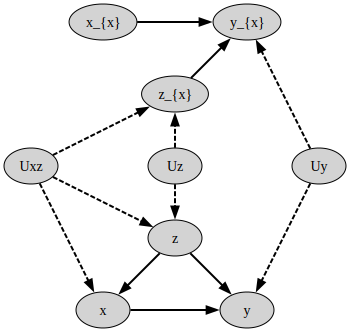

In [123]:
v1 = ex_TWN.v
v2 = ex_TWN.do({x}).v

bad_twn = CausalGraph(
    v = [v1.x,v1.y,v1.z,v2.x,v2.y,v2.z],
    directed_edges=[
        (v1.x,v1.y),
        (v2.x,v2.y),
        (v1.z,v1.y),
        (v2.z,v2.y),
        (v1.z,v1.x),
    ],
    bidirected_edges=[
        (v1.z,v2.z),
        (v1.x,v2.z),
        (v1.x,v1.z),
        (v1.z,v2.z),
        (v1.y,v2.y)
    ]
)

u = bad_twn.u

bad_twn.draw(node_positions={
    z: (0,-1),
    x: (-1,-2),
    y: (1,-2),
    x_x: (-1,2),
    y_x: (1,2),
    z_x: (0,1),
    u['Uy']: (2,0),
    u['Uxz']: (-2,0),
    u['Uz']: (0,0),
    
},include_u=True)

From the proper TWN, we know that $Y_x \perp X | Z$.

Yet in this improperly constructed graph, we find that the above expression is False.

In [124]:
bad_twn.is_d_separator(y_x,x,given={z})

False

## Multi-World Network (MWN) Algorithm

The graph separation tools and corresponding independence relations among counterfactual variables considered so far can be extended naturally to systems involving multiple worlds.

Building on the Twin Network framework, we introduce a new algorithm called **MWN-Construct()** (Algorithm 10) that will generate what is called the **Multiple-Worlds Network**.

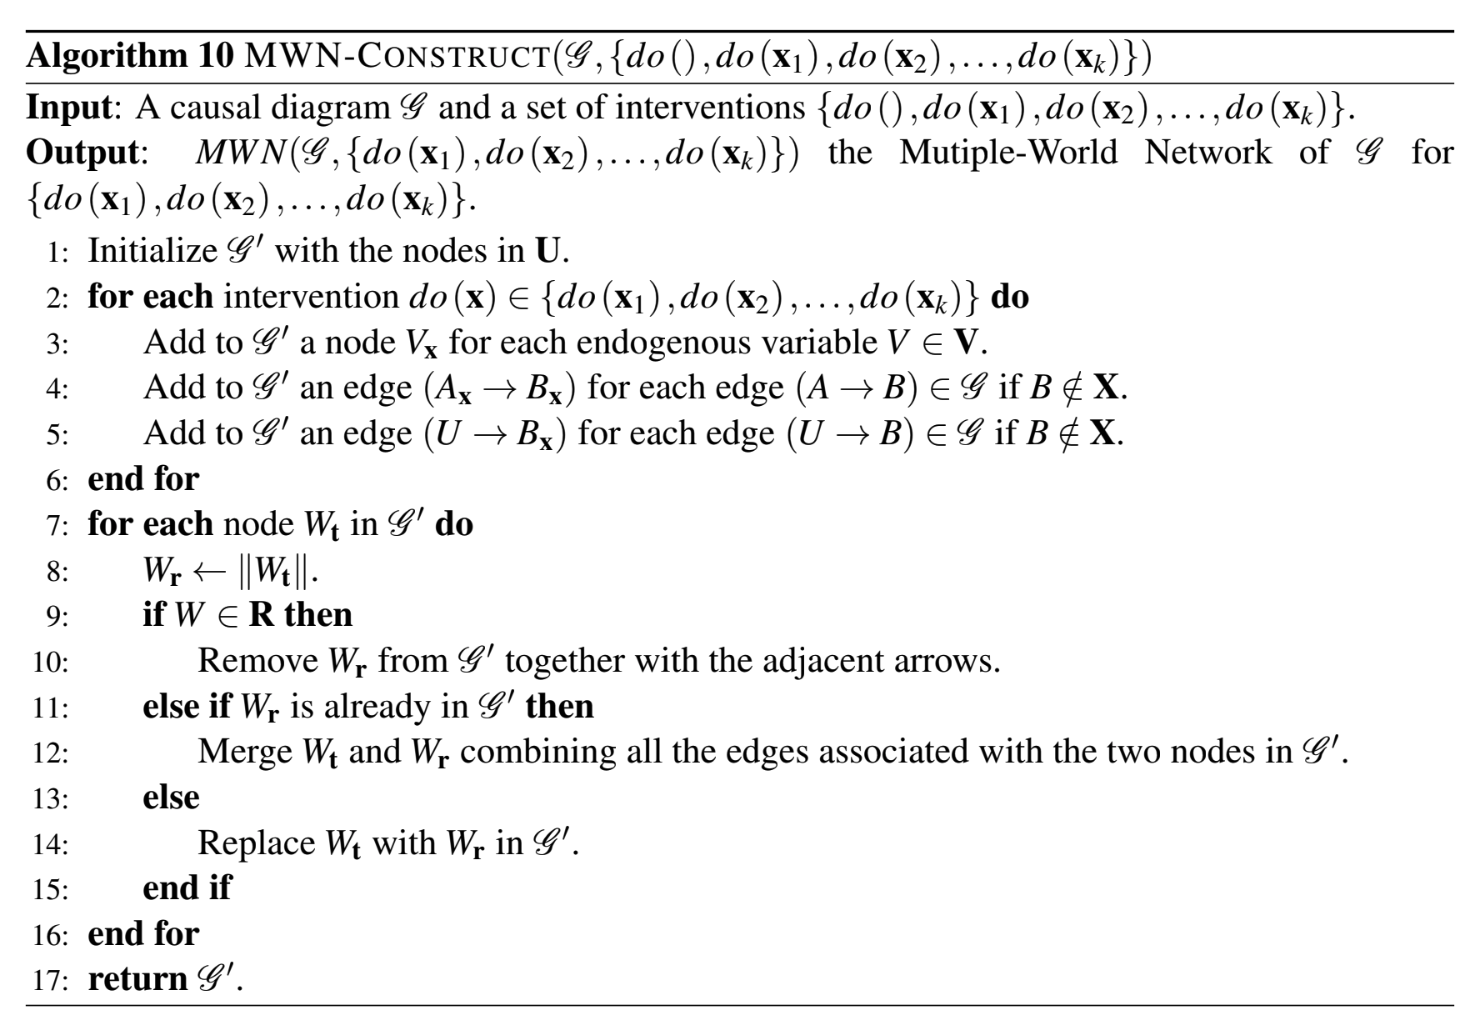

### Example 5.18 -- Multiple-worlds Method

Consider the causal diagram below and the task of evaluating the separation statement involving multiple counterfactuals, i.e.:

$$(Y_{xw}, W_{x'} \perp X | Z_{x'})$$

In [125]:
x,y,w,z = variables('x y w z')

ex_5_18 = CausalGraph(
    v = [x,y,w,z],
    directed_edges=[
        (x,w),
        (w,y),
        (z,y),
        (z,x)
    ]
)

In [126]:
ex_5_18_mwn = ex_5_18.build_MWN({x},{w,x})

In [127]:
v = ex_5_18_mwn.v
u = ex_5_18_mwn.u

z = v.z
y, y_w, y_x = v.y
x = v.x
w, w_x = v.w

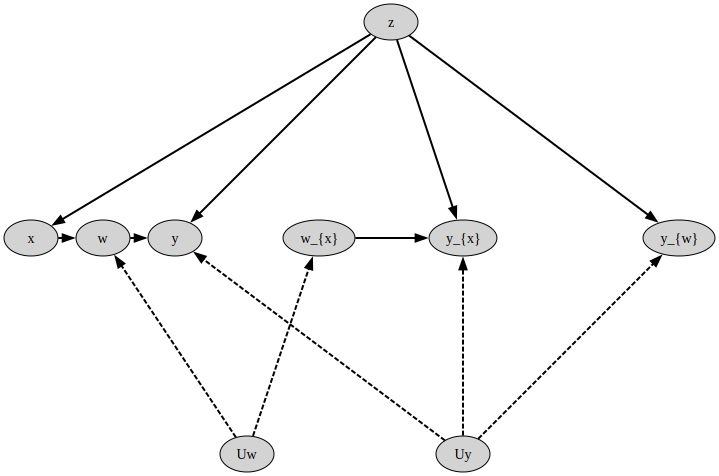

In [128]:
ex_5_18_mwn.draw(node_positions={
    z: (0,3),
    u['Uy']: (1, -3),
    u['Uw']:(-2,-3),
    x: (-5,0),
    w: (-4,0),
    y: (-3,0),
    w_x: (-1,0),
    y_x: (1,0),
    y_w: (4,0)
    
    },include_u=True)

The exclusion operator should be applied to arrive at the equivalent and more visibly true expression:

$$Y_{w}, W_{x'} \perp X | Z$$

In [129]:
y_xw = ex_5_18.do({x,w}).v.y
w_x = ex_5_18.do({x}).v.w
z_x = ex_5_18.do({x}).v.z

display(Latex(f'$||{y_xw}|| = '+str(ex_5_18.apply_exclusion_var(y_xw)) + "$"))
display(Latex(f'$||{w_x}|| = '+str(ex_5_18.apply_exclusion_var(w_x)) + "$"))
display(Latex(f'$||{z_x}|| = '+str(ex_5_18.apply_exclusion_var(z_x)) + "$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [130]:
ex_5_18_mwn.is_d_separator({y_w,w_x},x,given={z})

True

## The Ancestral Multi-World Network (AMWN) Network

In this section, we develop a more efficient approach to evaluating counterfactual separation. We start by noting something interesting in the previous example: only the paths involving ancestors of the variables considered in the query are relevant. This is
not a coincidence and follows from the fact that all paths through the descendants of a variable are
necessarily blocked.

To realize our goal, we will leverage a structure discussed earlier in this chapter called counterfactual ancestors (Def. 5.2.1). In particular, we will introduce the **Ancestral Multi-World Network**, whose construction is described in the **AMWN-Construct()** (Algorithm 11). For concreteness, consider the evaluation of the counterfactual query $(Y_{xw}, W_{x'} \perp X)$.

We derive the answers of each variable in the expression:

In [131]:
ex_5_18.get_ctf_ancestors({y_xw,w_x,x})

[x, y_{w}, w_{x}, z]

These are the nodes we will use to construct our AMWN.

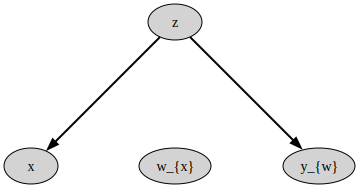

In [132]:
ex_5_18_amwn = ex_5_18.build_AMWN({y_xw,w_x,x})
ex_5_18_amwn.draw(
    node_positions={
        z: (0,2),
        x: (-2,0),
        w_x: (0,0),
        y_w: (2,0)
        
    }
)

The **AMWN** will play a central role in reading separation statements between counterfactual variables and will usually evoke a smaller subset of variables. That is, $(X_t \perp Y_r \mid Z_*)$ can be judged using d-separation on top of $G_A(X_t, Y_r, Z_*)$ as stated next.

## Theorem 5.3.4 — Counterfactual d-separation.

Consider a causal diagram $G$ and a collection of distributions $P_{***}$ induced by the SCM, including observational, interventional, and counterfactual. For counterfactual variables $X_t, Y_r, Z_*$,

$$
(||{X_t}|| \perp ||{Y_r}|| \mid ||{Z_*}||)_{G_A} \leftarrow (||{X_t}|| \perp ||{Y_r}|| \mid ||{Z_*}||)_{P_{***}}.
$$

In words, if $||X_t||$ and $||Y_r||$ are de-separated given $||Z_*||$ in the AMWN $G_A(X_t,Y_r,Z_*)$, then $X_t$ and $Y_r$ are independent given $Z_*$ in every distribution $P_{***}$ with the causal diagram $G$.


### Example 5.19 -- Checking ctf-separation via AMWN

Consider the following graph and whether $X \perp Y_x$.

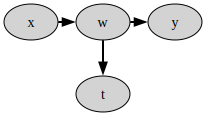

In [133]:
x,w,t,y = variables('x w t y')

ex_5_19 = CausalGraph(
    v = [x,w,t,y],
    directed_edges=[
        (x,w),
        (w,y),
        (w,t),
    ]
)

ex_5_19.draw(node_positions={
    x: (-1, 0),
    w: (0, 0),
    t: (0, -1),
    y: (1, 0)
})

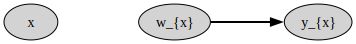

In [134]:
y_x = ex_5_19.do({x}).v.y

ex_5_19_amwn = ex_5_19.build_AMWN({y_x,x})

ex_5_19_amwn.draw(node_positions={
    x: (-2,0),
    w_x: (0,0),
    y_x: (2,0)}
)

In [135]:
ex_5_19_amwn.is_d_separator(x,y_x)

True

Next, we consider whether $T_w \perp Y_x | T_x$.

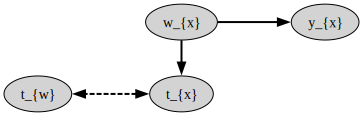

In [136]:
t_w = ex_5_19.do({w}).v.t
t_x = ex_5_19.do({x}).v.t

ex_5_19_amwn2 = ex_5_19.build_AMWN({t_w,t_x,y_x})

ex_5_19_amwn2.draw(node_positions={
    w_x: (0,0),
    y_x: (2,0),
    t_w: (-2,-1),
    t_x: (0,-1)}
)

In [137]:
ex_5_19_amwn2.is_d_separator(t_w,y_x,given={t_x})

False

### Example 5.20 -- Checking ctf-separation via AMWN

Consider the following diagram and the separation statement $(X \perp Z_x | Y)$

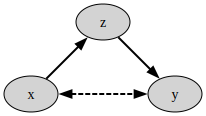

In [138]:
x,y,z = variables('x y z')

ex_5_20 = CausalGraph(
    v=[x,y,z],
    directed_edges=[
        (x,z),
        (z,y)
    ],
    bidirected_edges=[
        (x,y)
    ]
)

ex_5_20.draw(node_positions={
    x: (-1, 0),
    y: (1, 0),
    z: (0, 1)
})

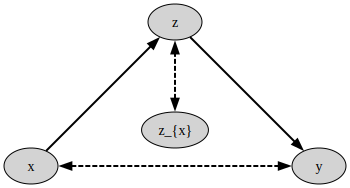

In [139]:
z_x = ex_5_20.do({x}).v.z

ex_5_20_amwn = ex_5_20.build_AMWN({z_x,x,y})

ex_5_20_amwn.draw(node_positions={
    x: (-2,-1),
    y: (2,-1),
    z_x: (0,-.5),
    z: (0,1),}
)

In [140]:
ex_5_20_amwn.is_d_separator(x, z_x, given={y})

False

Now consider whether $(Y \perp Z_x | Z)$ holds in the same diagram.

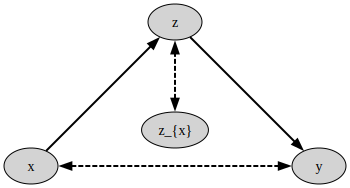

In [141]:
z_x = ex_5_20.do({x}).v.z

ex_5_20_amwn2 = ex_5_20.build_AMWN({z_x,z,y})
ex_5_20_amwn2.draw(node_positions={
    x: (-2,-1),
    y: (2,-1),
    z_x: (0,-.5),
    z: (0,1),}
)

In [142]:
ex_5_20_amwn2.is_d_separator(y, z_x, given={z})

False

Finally, consider whether conditional ignorability holds in this diagram, namely $(Y_x \perp X | Z)$.

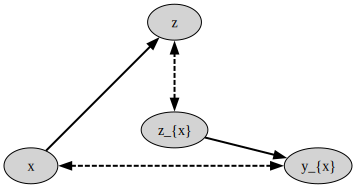

In [143]:
y_x = ex_5_20.do({x}).v.y

ex_5_20_amwn3 = ex_5_20.build_AMWN({z,x,y_x})

ex_5_20_amwn3.draw(node_positions={
    x: (-2,-1),
    y_x: (2,-1),
    z: (0,1),
    z_x: (0,-.5)}
)

In [144]:
ex_5_20_amwn3.is_d_separator(x, y_x, given={z})

False

### Example 5.21 -- Another counterfactual d-separation instance

Consider the causal diagram below and whether $Y_{xw}$ is independent of $X$ given $\{Z,W\}$.

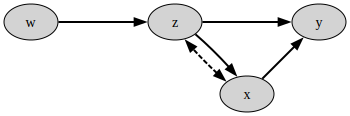

In [145]:
x,y,z,w = variables('x y z w')

ex_5_21 = CausalGraph(
    v = [x,y,z,w],
    directed_edges=[
        (w,z),
        (z,y),
        (z,x),
        (x,y)
    ],
    bidirected_edges=[
        (x,z)
    ]
)
ex_5_21.draw(node_positions={
    x: (-1, -1),
    y: (0, 0),
    z: (-2, 0),
    w: (-4, 0)
})

In [146]:
y_xw = ex_5_21.do({x,w}).v.y

ex_5_21.is_ctf_d_separator(x,y_xw,given={z,w})

False

## The Counterfactual-calculus

# Theorem 5.3.5 -- Counterfactual Calculus (ctf-calculus)

Let $G$ be a causal diagram, then for $Y, X, Z, W, T \subseteq V$, the following rules hold for the probability distributions generated by any model compatible with $G$:

**Rule 1 (Consistency rule — Observation/intervention exchange)**

$$
P(y_T x, x_T, w_*) = P(y_T, x_T, w_*)
$$

**Rule 2 (Independence Rule — Adding/removing counterfactual observations)**

$$
P(y_r \mid x_t, w_*) = P(y_r \mid w_*) \quad \text{if} \quad (Y_r \perp X_t \mid W_*) \, \text{in} \, G_A
$$

**Rule 3 (Exclusion Rule — Adding/removing interventions)**

$$
P(y_{xz}, w_*) = P(y_z, w_*) \quad \text{if} \quad X \cap An(Y) = \emptyset \, \text{in} \, G_{\overline{Z}}
$$

where $G_A$ is the counterfactual ancestral graph $G_A(Y_r, X_t, W_*)$.


The first rule of the calculus, consistency, was discussed extensively in Section 5.3.1. One
distinct feature of this rule is that it does not depend on the graphical structure and allows for
adding or removing interventions whenever a specific observational context and the antecedent of
the counterfactual (subscript) match. Consistency is essentially the probabilistic instantiation of
the invariances that follow from the modularity and stability of the system’s causal mechanisms.

The second rule, independence (Section 5.3.3), corresponds to a generalized version of d-
separation for counterfactual events. In terms of syntax, it permits adding and removing counter-
factual evidence in a probability distribution.

The third rule, exclusion (Section 5.3.2), follows from the idea that interventions on variables
without a causal path to the observed variable do not affect this variable and, therefore, can be
dismissed.

## Definition 5.3.2 -- Counterfactual Identification

A counterfactual distribution $P(Y_* = y_*)$ is said to be identifiable from $\mathbb{Z}$ in $G$ if $P(Y_* = y_*)$ is uniquely computable from the distributions $\{P_{z_j}(V) > 0 \}_{z_j \in Val(Z_j), Z_j \in \mathbb{Z}}$ in any causal model that induces $G$.

That is, for any two models $M^{(1)}$ and $M^{(2)}$ with causal diagram $G$, $\{P_{z_j}(V) > 0 \}_{z_j \in Val(Z_j), Z_j \in \mathbb{Z}}$ implies $P^{(1)}(Y_* = y_*) = P^{(2)}(Y_* = y_*)$.

Similarly to causal effect identifiability (Def. 4.2.1), counterfactual identifiability formalizes
the decision problem that asks whether the assumptions encoded in the causal diagram together
with the available distributions are enough to infer a target counterfactual query.

We illustrate next the use of the ctf-calculus rules for this identification task through a few
examples.

### Example 5.22 -- ETT in the Backdoor Diagram

Consider the backdoor causal diagram below and the observational distribution as input, and the counterfactual distribution $P(y_x | x')$ as the query.

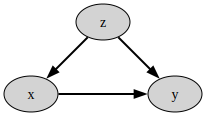

In [147]:
x,y,z = variables('x y z')

ex_5_22 = CausalGraph(
    v= [x,y,z],
    directed_edges=[
        (x,y),
        (z,y),
        (z,x)
    ]
)

ex_5_22.draw(node_positions={
    x: (-1, 0),
    y: (1, 0),
    z: (0, 1)
})

Using ctf-calculus, we can derive an identifiability expression:

In [148]:
y_x = ex_5_20.do({x:1}).v.y

exp = Pr({y_x},{x:0})
exp

P\left(y_{x=1} \mid x = 0\right)

Condition on Z:

In [149]:
exp = Summation(Pr({y_x},{x:0,z:z}) * Pr({z:z},{x:0}),z)
exp

\sum_{z}{P\left(z = z \mid x = 0\right)*P\left(y_{x=1} \mid x = 0, z = z\right)}

In [150]:
tgt = [pr for pr in exp.atoms(Pr) if y_x in pr.get_event()][0]
sub = tgt.apply_bayes()
num = [pr for pr in sub.atoms(Pr) if y_x in pr.get_event()][0]
denom = [pr for pr in sub.atoms(Pr) if y_x not in pr.get_event()][0]
new_num = ex_5_22.apply_r3(num, target_var={z}, intervention_var={x:1}, method='add')
new_denom = ex_5_22.apply_r3(denom, target_var={z}, intervention_var={x:1}, method='add')

z_x = new_denom.vars.z

sub = sub.subs({num: new_num, denom: new_denom})
exp = exp.subs({tgt : sub})
exp

\sum_{z}{P\left(y_{x=1}, x = 0, z_{x=1} = z\right)*P\left(z = z \mid x = 0\right)/P\left(x = 0, z_{x=1} = z\right)}

In [151]:
tgt = [pr for pr in exp.atoms(Pr) if y_x in pr.get_event()][0]
r1 = ex_5_22.apply_r1(tgt, target_var={y_x}, intervention_var=z, method='add')

y_xz = r1.vars.y

exp = exp.subs({tgt: r1})
exp

\sum_{z}{P\left(z = z \mid x = 0\right)*P\left(y_{x=1,z=z}, x = 0, z_{x=1} = z\right)/P\left(x = 0, z_{x=1} = z\right)}

In [152]:
tgt1 = [pr for pr in exp.atoms(Pr) if y_xz in pr.get_event()][0]
tgt2 = [pr for pr in exp.atoms(Pr) if (x in pr.get_event() and z_x in pr.get_event() and y_xz not in pr.get_event())][0]

tgt1_r3 = ex_5_22.apply_r3(tgt1, target_var={z_x}, intervention_var=x, method='remove')
tgt2_r3 = ex_5_22.apply_r3(tgt2, target_var={z_x}, intervention_var=x, method='remove')

exp = exp.subs({tgt1: tgt1_r3, tgt2: tgt2_r3})
exp

\sum_{z}{P\left(y_{x=1,z=z}, x = 0, z = z\right)*P\left(z = z \mid x = 0\right)/P\left(x = 0, z = z\right)}

In [153]:
num = [pr for pr in exp.atoms(Pr) if y_xz in pr.get_event()][0]
denom = [pr for pr in exp.atoms(Pr) if (z in pr.get_event() and x in pr.get_event() and y_xz not in pr.get_event())][0]

combined = Pr.apply_bayes_inverse(num/denom)

exp = exp.subs({num: combined, denom: 1})
exp

\sum_{z}{P\left(y_{x=1,z=z} \mid x = 0, z = z\right)*P\left(z = z \mid x = 0\right)}

In [154]:
tgt = [pr for pr in exp.atoms(Pr) if y_xz in pr.get_event()][0]

tgt_r2 = ex_5_22.apply_r2(tgt, target_var={x}, method='remove')
tgt_r2 = ex_5_22.apply_r2(tgt_r2, target_var={x:1}, method='add')

exp = exp.subs({tgt: tgt_r2})
exp

\sum_{z}{P\left(z = z \mid x = 0\right)*P\left(y_{x=1,z=z} \mid z = z, x = 1\right)}

In [155]:
tgt = [pr for pr in exp.atoms(Pr) if y_xz in pr.get_event()][0]

tgt_bayes = tgt.apply_bayes()

num = [pr for pr in tgt_bayes.atoms(Pr) if y_xz in pr.get_event()][0]
denom = [pr for pr in tgt_bayes.atoms(Pr) if y_xz not in pr.get_event()][0]

num_r1 = ex_5_22.apply_r1(num, target_var={y_xz}, intervention_var={x:1,z:z}, method='remove')

tgt_rev = Pr.apply_bayes_inverse(num_r1/denom)

exp = exp.subs({tgt: tgt_rev})
exp

\sum_{z}{P\left(z = z \mid x = 0\right)*P\left(y \mid z = z, x = 1\right)}

The effect of treatment on the treated is then identifiable from $P(v)$ and $G$.

### Example 5.23 -- ETT in the Front-door Case

Consider the following graph and the task of identifying the ETT from the observational distribution.

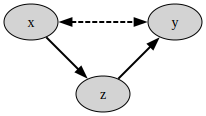

In [156]:
ex_5_23 = CausalGraph(
    v = [x,y,z],
    directed_edges=[
        (x,z),
        (z,y)
    ],
    bidirected_edges=[
        (x,y)
    ]
)

ex_5_23.draw(node_positions={
    x: (-1, 0),
    y: (1, 0),
    z: (0, -1)
})

We can then write based on ctf-calculus:

In [157]:
y_x = ex_5_23.do({x:1}).v.y

Pr({y_x},{x:0})

P\left(y_{x=1} \mid x = 0\right)

Conditioning on $Z_x$

In [158]:
z_x = ex_5_23.do({x:1}).v.z

exp = Summation(Pr({y_x},{x:0,z_x:z}) * Pr({z_x:z},{x:0}),z)
exp

\sum_{z}{P\left(z_{x=1} = z \mid x = 0\right)*P\left(y_{x=1} \mid x = 0, z_{x=1} = z\right)}

In [159]:
tgt = [pr for pr in exp.atoms(Pr) if y_x in pr.get_event()][0]

tgt_bayes = tgt.apply_bayes()

exp = exp.subs({tgt: tgt_bayes})

num = [pr for pr in exp.atoms(Pr) if y_x in pr.get_event()][0]

num_r1 = ex_5_23.apply_r1(num, target_var={y_x}, intervention_var={z}, method='add')

y_xz_x = num_r1.vars.y

exp = exp.subs({num: num_r1})
exp

\sum_{z}{P\left(z_{x=1} = z \mid x = 0\right)*P\left(y_{x=1,z=z}, x = 0, z_{x=1} = z\right)/P\left(x = 0, z_{x=1} = z\right)}

In [160]:
tgt = [pr for pr in exp.atoms(Pr) if y_xz_x in pr.get_event()][0]

tgt_r3 = ex_5_23.apply_r3(tgt, target_var={y_xz_x}, intervention_var={x}, method='remove')

y_z = tgt_r3.vars.y

exp = exp.subs({tgt: tgt_r3})
exp

\sum_{z}{P\left(z_{x=1} = z \mid x = 0\right)*P\left(y_{z=z}, x = 0, z_{x=1} = z\right)/P\left(x = 0, z_{x=1} = z\right)}

In [161]:
num = [pr for pr in exp.atoms(Pr) if y_z in pr.get_event()][0]
denom = [pr for pr in exp.atoms(Pr) if (x in pr.get_event() and y_z not in pr.get_event())][0]

tgt_bayes = Pr.apply_bayes_inverse(num/denom)

exp = exp.subs({num: tgt_bayes, denom: 1})

tgt_r2 = ex_5_23.apply_r2(tgt_bayes, target_var={z_x}, method='remove')

exp = exp.subs({tgt_bayes: tgt_r2})
exp

\sum_{z}{P\left(z_{x=1} = z \mid x = 0\right)*P\left(y_{z=z} \mid x = 0\right)}

In [162]:
z_x0 = ex_5_23.do({x:0}).v.z

tgt = [pr for pr in exp.atoms(Pr) if y_z in pr.get_event()][0]

tgt_r2 = ex_5_23.apply_r2(tgt, target_var={z_x0:z}, method='add')

exp = exp.subs({tgt: tgt_r2})
exp

\sum_{z}{P\left(z_{x=1} = z \mid x = 0\right)*P\left(y_{z=z} \mid x = 0, z_{x=0} = z\right)}

In [163]:
tgt = [pr for pr in exp.atoms(Pr) if y_z in pr.get_event()][0]

tgt_bayes = tgt.apply_bayes()
num = [pr for pr in tgt_bayes.atoms(Pr) if y_z in pr.get_event()][0]
denom = [pr for pr in tgt_bayes.atoms(Pr) if y_z not in pr.get_event()][0]

num_r1 = ex_5_23.apply_r1(num, target_var={z_x0}, intervention_var={x}, method='remove')
denom_r1 = ex_5_23.apply_r1(denom, target_var={z_x0}, intervention_var={x}, method='remove')

exp = exp.subs({tgt: tgt_bayes})
exp = exp.subs({num: num_r1, denom: denom_r1})
exp

\sum_{z}{P\left(y_{z=z}, x = 0, z = z\right)*P\left(z_{x=1} = z \mid x = 0\right)/P\left(x = 0, z = z\right)}

In [164]:
tgt = [pr for pr in exp.atoms(Pr) if y_z in pr.get_event()][0]

r1 = ex_5_23.apply_r1(tgt, target_var={y_z}, intervention_var={z}, method='remove')

exp = exp.subs({tgt: r1})
exp

\sum_{z}{P\left(z_{x=1} = z \mid x = 0\right)*P\left(y, x = 0, z = z\right)/P\left(x = 0, z = z\right)}

In [166]:
tgt = [pr for pr in exp.atoms(Pr) if z_x in pr.get_event()][0]

r2 = ex_5_23.apply_r2(tgt, target_var={x}, method='remove')
r2 = ex_5_23.apply_r2(r2, target_var={x:1}, method='add')

exp = exp.subs({tgt: r2})
exp

\sum_{z}{P\left(y, x = 0, z = z\right)*P\left(z_{x=1} = z \mid x = 1\right)/P\left(x = 0, z = z\right)}

In [168]:
tgt = [pr for pr in exp.atoms(Pr) if z_x in pr.get_event()][0]

tgt_bayes = tgt.apply_bayes()
num = [pr for pr in tgt_bayes.atoms(Pr) if z_x in pr.get_event()][0]
denom = [pr for pr in tgt_bayes.atoms(Pr) if z_x not in pr.get_event()][0]

r1 = ex_5_23.apply_r1(num, target_var={z_x}, intervention_var={x}, method='remove')

exp = exp.subs({tgt: r1/denom})
exp

\sum_{z}{P\left(y, x = 0, z = z\right)*P\left(z = z, x = 1\right)/(P\left(x = 0, z = z\right)*P\left(x = 1\right))}

In [169]:
tgt1_num = [pr for pr in exp.atoms(Pr) if y in pr.get_event()][0]
tgt1_denom = [pr for pr in exp.atoms(Pr) if (pr.get_event()[x]==0 and y not in pr.get_event())][0]

tgt2_num = [pr for pr in exp.atoms(Pr) if z in pr.get_event() and pr.get_event()[x]==1][0]
tgt2_denom = [pr for pr in exp.atoms(Pr) if (pr.get_event()[x]==1 and z not in pr.get_event())][0]

tgt1_bayes = Pr.apply_bayes_inverse(tgt1_num/tgt1_denom)
tgt2_bayes = Pr.apply_bayes_inverse(tgt2_num/tgt2_denom)

exp = exp.subs({tgt1_num: tgt1_bayes, tgt1_denom: 1})
exp = exp.subs({tgt2_num: tgt2_bayes, tgt2_denom: 1})
exp

\sum_{z}{P\left(y \mid x = 0, z = z\right)*P\left(z = z \mid x = 1\right)}